In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import docx
import seaborn as sns
import os

In [4]:
# Create a new folder to store the output files
if not os.path.exists('plots'):
    os.makedirs('plots')

In [5]:
def dataframe2table(document, file_name, df, style_table='Table Grid', col='Variable'):
    df[f'{col}'] = df.index 
    # Reorder the columns so the index is the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    # Add the dataframe to the docx file
    table = document.add_table(rows=df.shape[0]+1, cols=df.shape[1])
    table.style = style_table
    # Add the header rows.
    for j in range(df.shape[-1]):
        table.cell(0,j).text = df.columns[j]
    # Add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            table.cell(i+1,j).text = str(df.values[i,j])

    # Add \n\n to the document
    document.add_paragraph('')

    # Save the document
    document.save(file_name)

In [6]:
def plot2doc(document, file_name, fig, w=6, h=6):
    p = document.add_paragraph()
    r = p.add_run()
    r.add_picture(fig, width=docx.shared.Inches(w), height=docx.shared.Inches(h))
    document.add_paragraph('')
    document.save(file_name)

In [7]:
heading_index = 1

In [8]:
# Link of the repository (large files)
repo = 'https://media.githubusercontent.com/media/cBioPortal/datahub/master/public'

In [9]:
#Files with the data
files=('data_clinical_patient.txt', 'data_clinical_sample.txt')
tcga = '_tcga_pan_can_atlas_2018'

In [10]:
# TCGA studies excluded leukemia and lymphoma
studies=('acc', 'blca', 'brca', 'cesc','chol', 'coadread', 
        'esca', 'gbm', 'hnsc', 'kich', 'kirc', 'kirp', 'laml', 'lgg', 'lihc', 'luad', 'lusc', 'meso', 'ov',
        'paad', 'pcpg', 'prad', 'sarc', 'skcm', 'stad', 'tgct', 'thca', 'thym', 'ucec', 'ucs'
)

In [11]:
# Create the columns of the final dataset
column_names=['SAMPLE_ID', 'PATIENT_ID', 'SEX', 'RACE', 'ETHNICITY', 'AGE', 'CANCER_TYPE', 'ONCOTREE_CODE','CANCER_TYPE_DETAILED', 'SAMPLE_TYPE', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'HISTORY_NEOADJUVANT_TRTYN']

# Create the dataset
dataset = pd.DataFrame(columns=column_names)

In [12]:
for study in studies:
    print('Processing study: ' + study)

    # Get the clinical data
    # print('Processing clinical data')
    clinical_data = repo + '/' + study + tcga + '/' + files[0]
    clinical_df =  pd.read_csv(clinical_data, sep='\t', dtype=str, header=4, usecols = ['PATIENT_ID', 'SEX', 'RACE','ETHNICITY', 'AGE', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'HISTORY_NEOADJUVANT_TRTYN'])
    # print(clinical_df.info())

    # Get the sample data
    # print('Processing sample data')
    samples_cols = ['PATIENT_ID', 'SAMPLE_ID', 'CANCER_TYPE', 'ONCOTREE_CODE','CANCER_TYPE_DETAILED', 'SAMPLE_TYPE']
    sample_data =  repo + '/' + study + tcga + '/' + files[1]
    sample_df =  pd.read_csv(sample_data, sep='\t', dtype=str, header=4, usecols = samples_cols)
    # print(sample_df.info())

    # Merge the dataframes
    data_df = pd.merge(clinical_df, sample_df, how='inner', on='PATIENT_ID')

    # Order the resulting dataframe
    order = ['SAMPLE_ID', 'PATIENT_ID', 'AGE', 'SEX', 'RACE', 'ETHNICITY', 'CANCER_TYPE', 'ONCOTREE_CODE', 'CANCER_TYPE_DETAILED', 'SAMPLE_TYPE', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'HISTORY_NEOADJUVANT_TRTYN']
    data_df = data_df[order]

    # Add the study data to the dataset
    dataset = pd.concat([dataset, data_df], ignore_index=True)


Processing study: acc
Processing study: blca
Processing study: brca
Processing study: cesc
Processing study: chol
Processing study: coadread
Processing study: esca
Processing study: gbm
Processing study: hnsc
Processing study: kich
Processing study: kirc
Processing study: kirp
Processing study: laml
Processing study: lgg
Processing study: lihc
Processing study: luad
Processing study: lusc
Processing study: meso
Processing study: ov
Processing study: paad
Processing study: pcpg
Processing study: prad
Processing study: sarc
Processing study: skcm
Processing study: stad
Processing study: tgct
Processing study: thca
Processing study: thym
Processing study: ucec
Processing study: ucs


In [13]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10839 entries, 0 to 10838
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   SAMPLE_ID                    10839 non-null  object
 1   PATIENT_ID                   10839 non-null  object
 2   SEX                          10141 non-null  object
 3   RACE                         8908 non-null   object
 4   ETHNICITY                    7687 non-null   object
 5   AGE                          10092 non-null  object
 6   CANCER_TYPE                  10839 non-null  object
 7   ONCOTREE_CODE                10839 non-null  object
 8   CANCER_TYPE_DETAILED         10839 non-null  object
 9   SAMPLE_TYPE                  10839 non-null  object
 10  AJCC_PATHOLOGIC_TUMOR_STAGE  6712 non-null   object
 11  HISTORY_NEOADJUVANT_TRTYN    10138 non-null  object
dtypes: object(12)
memory usage: 1016.3+ KB
None


In [14]:
sns.set_style("darkgrid", {"grid.color": "violet", "grid.linestyle": "--"})

In [15]:
# Cleaning and preprocessing of the dataset
# Change the data type of the column AGE to numeric
dataset['AGE'] = pd.to_numeric(dataset['AGE'], errors='coerce')
# Fix sex column
# Replace missing values with 'Female' for rows with 'Endometrial' and 'Ovarian' tumor type
dataset.loc[dataset['CANCER_TYPE'].str.contains('endometrial|ovarian', case=False, regex=True) & dataset['SEX'].isnull(), 'SEX'] = 'Female'

# Categorize the age column, creating a new column called 'AGE_GROUP'
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
dataset['AGE_GROUP'] = pd.cut(dataset['AGE'], bins=bins, labels=labels, right=False)
dataset['AGE_GROUP'] = pd.Categorical(dataset['AGE_GROUP'], categories=labels, ordered=True)

# Modify the value 'Yes (Pharmaceutical...)' to 'Pharma' in the column 'HISTORY_NEOADJUVANT_TRTYN'
dataset['HISTORY_NEOADJUVANT_TRTYN'] = dataset['HISTORY_NEOADJUVANT_TRTYN'].replace(regex='(?i).*pharma.*', value = 'Pharma')

In [16]:
# Check duplicated values
duplicates = dataset.duplicated()
print('Duplicated values: ' + str(duplicates.sum()))

Duplicated values: 0


In [17]:
# Remove the rows with missing values
dataset = dataset.dropna().reset_index(drop=True)

In [18]:
dataset.to_csv('TCGA_dataset.tsv', sep='\t', index=False)

In [19]:
# Read the dataset
#dataset = pd.read_csv('TCGA_dataset.tsv', sep='\t')

In [20]:
# Drop the columns SAMPLE_ID and PATIENT_ID
dataset.drop(columns=['SAMPLE_ID', 'PATIENT_ID'], inplace=True)

In [21]:
file_name = "TCGA_report.docx"
document = docx.Document()

In [22]:
print(dataset.info())
# Dump the dataset info to the docx file
document.add_heading(f'{heading_index}. Información del dataset', level=1)
heading_index += 1
document.add_paragraph('El dataset contiene ' + str(dataset.shape[0]) + ' muestras y ' + str(dataset.shape[1]) + ' columnas.')
document.add_paragraph('Las columnas o variables son:')
for column in dataset.columns:
    document.add_paragraph(column)

# Add \n\n to the document
document.add_paragraph('')

# Save the document
document.save(file_name)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   SEX                          5239 non-null   object  
 1   RACE                         5239 non-null   object  
 2   ETHNICITY                    5239 non-null   object  
 3   AGE                          5239 non-null   float64 
 4   CANCER_TYPE                  5239 non-null   object  
 5   ONCOTREE_CODE                5239 non-null   object  
 6   CANCER_TYPE_DETAILED         5239 non-null   object  
 7   SAMPLE_TYPE                  5239 non-null   object  
 8   AJCC_PATHOLOGIC_TUMOR_STAGE  5239 non-null   object  
 9   HISTORY_NEOADJUVANT_TRTYN    5239 non-null   object  
 10  AGE_GROUP                    5239 non-null   category
dtypes: category(1), float64(1), object(9)
memory usage: 414.7+ KB
None


In [23]:
cat_description = dataset.describe(include=['object'])
num_description = dataset.describe()
i = 1
# Add the categorical description to the document
document.add_heading(f'{i}. Descripción de variables categóricas', level=2)
i += 1
dataframe2table(document, file_name, cat_description.T)

# Add \n\n to the document
document.add_paragraph('')

# Add the numerical description to the document
document.add_heading(f'{i}. Descripción de variables numéricas', level=2)
dataframe2table(document, file_name, num_description.T)

In [24]:
# Tabla estilo Medium Shading Accent 2
style_table = 'Medium Shading 1 Accent 1'
categorical_columns = dataset.select_dtypes(include=['object', 'category']).columns

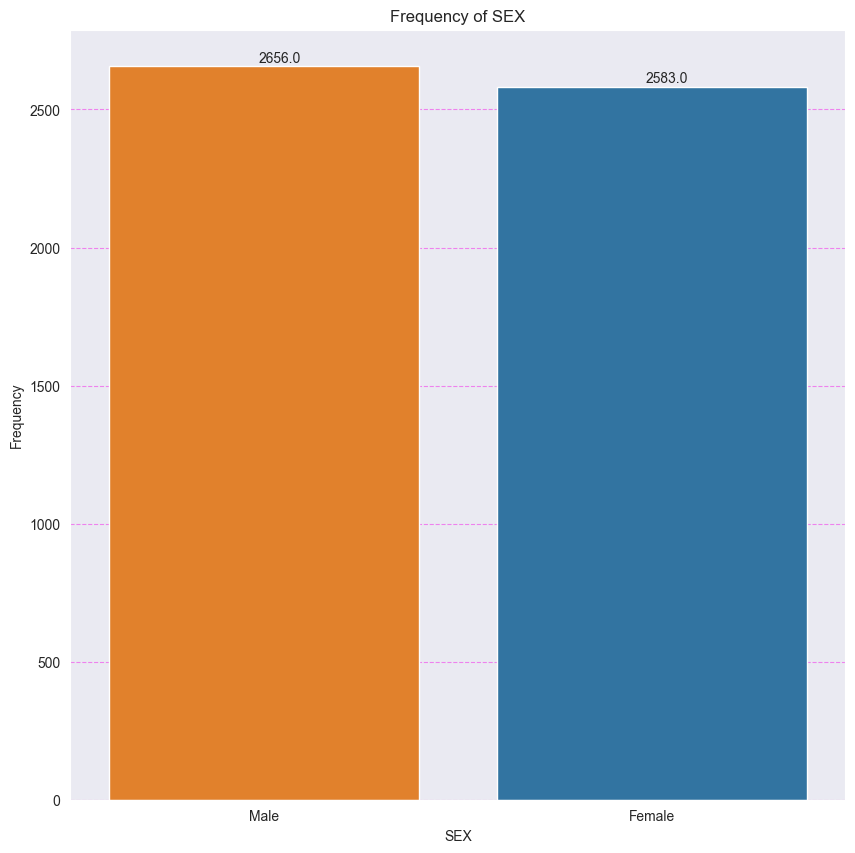

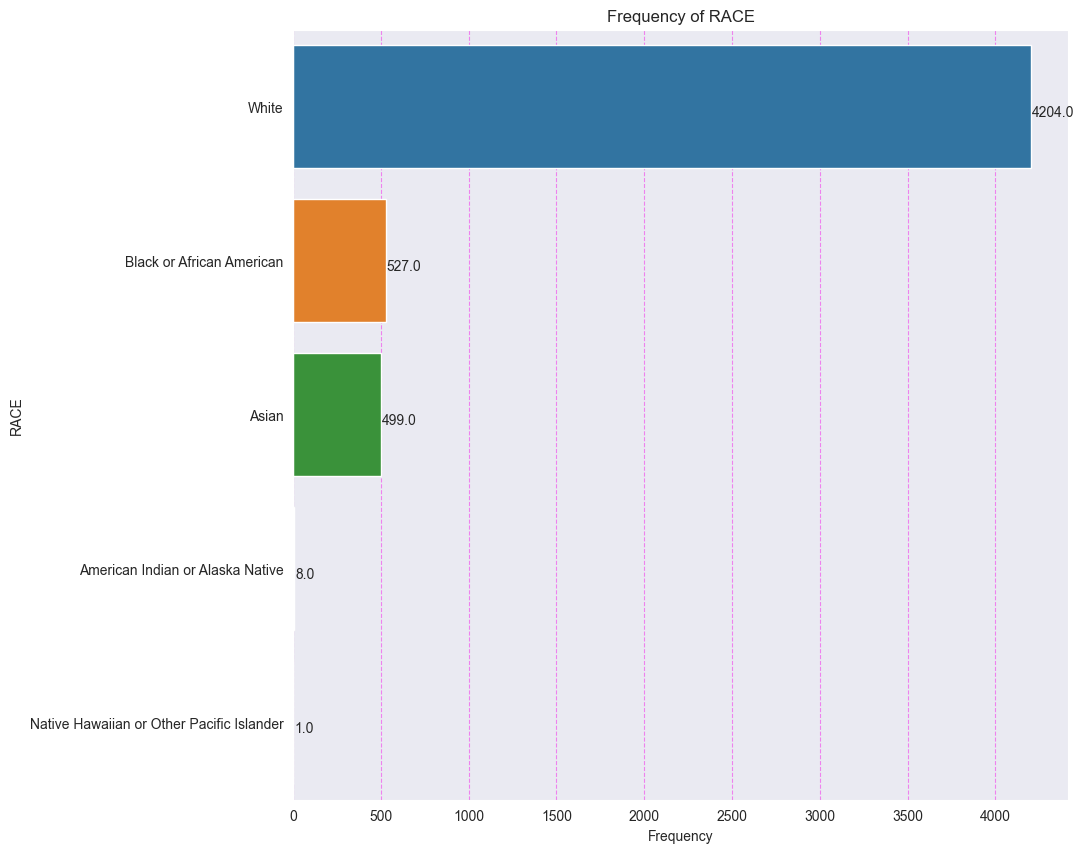

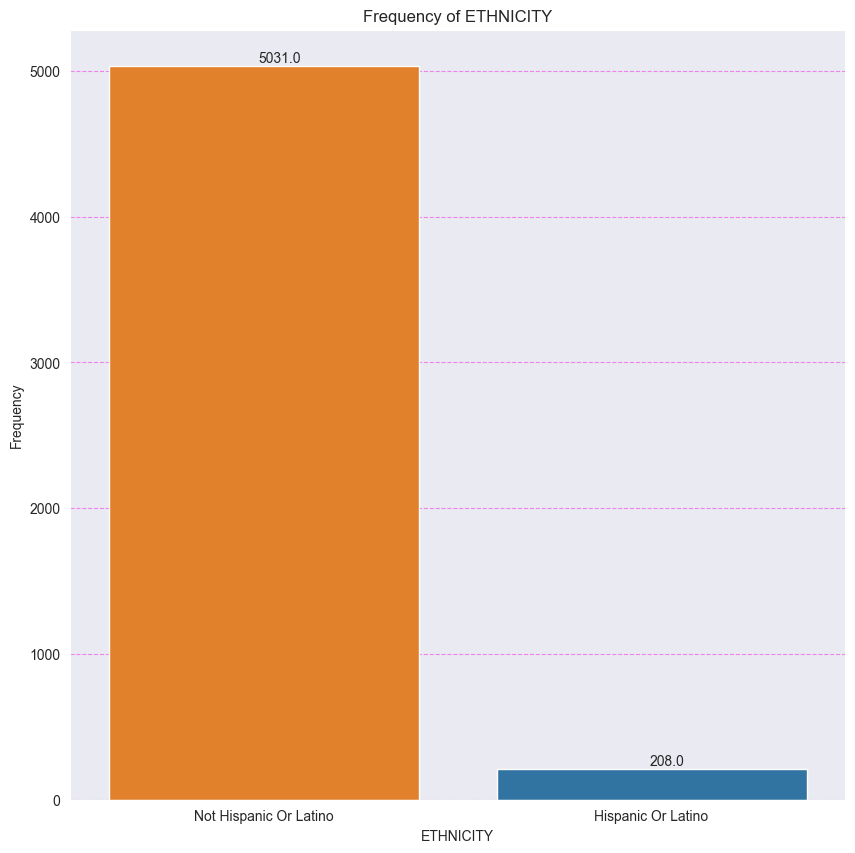

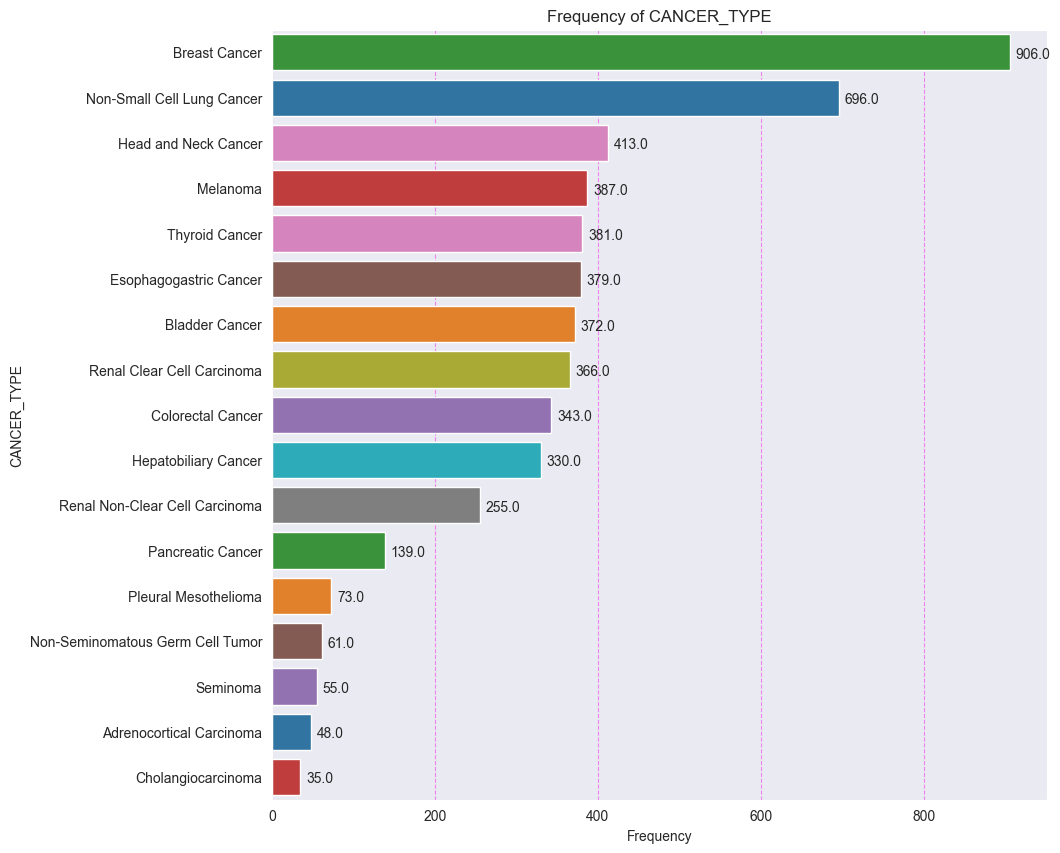

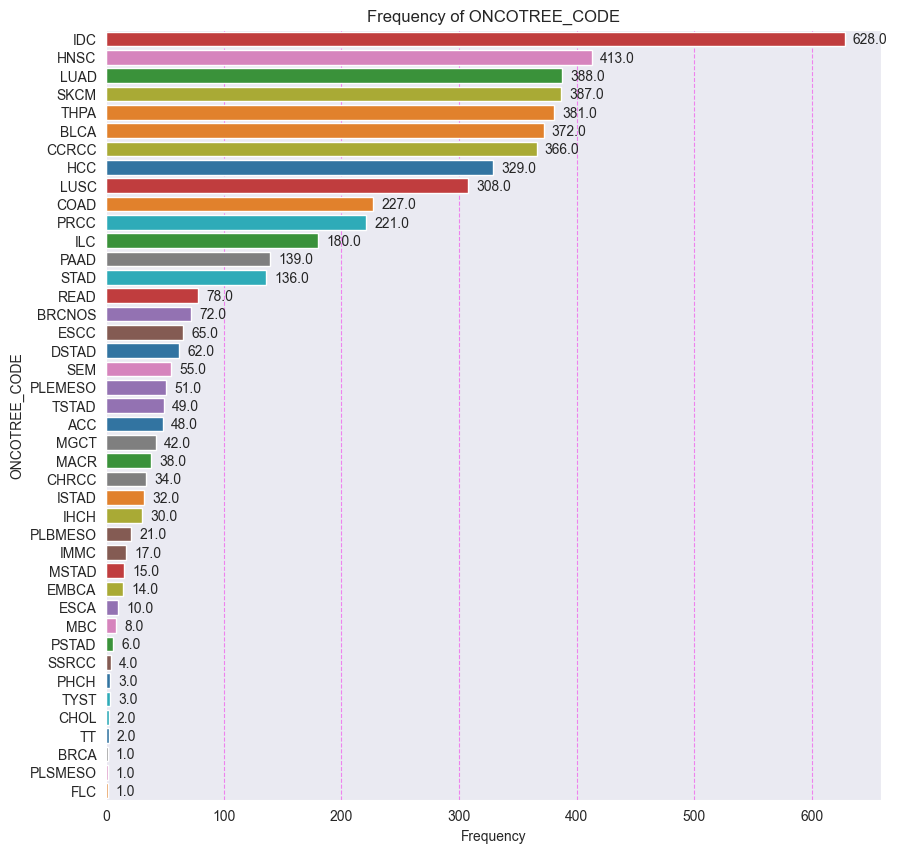

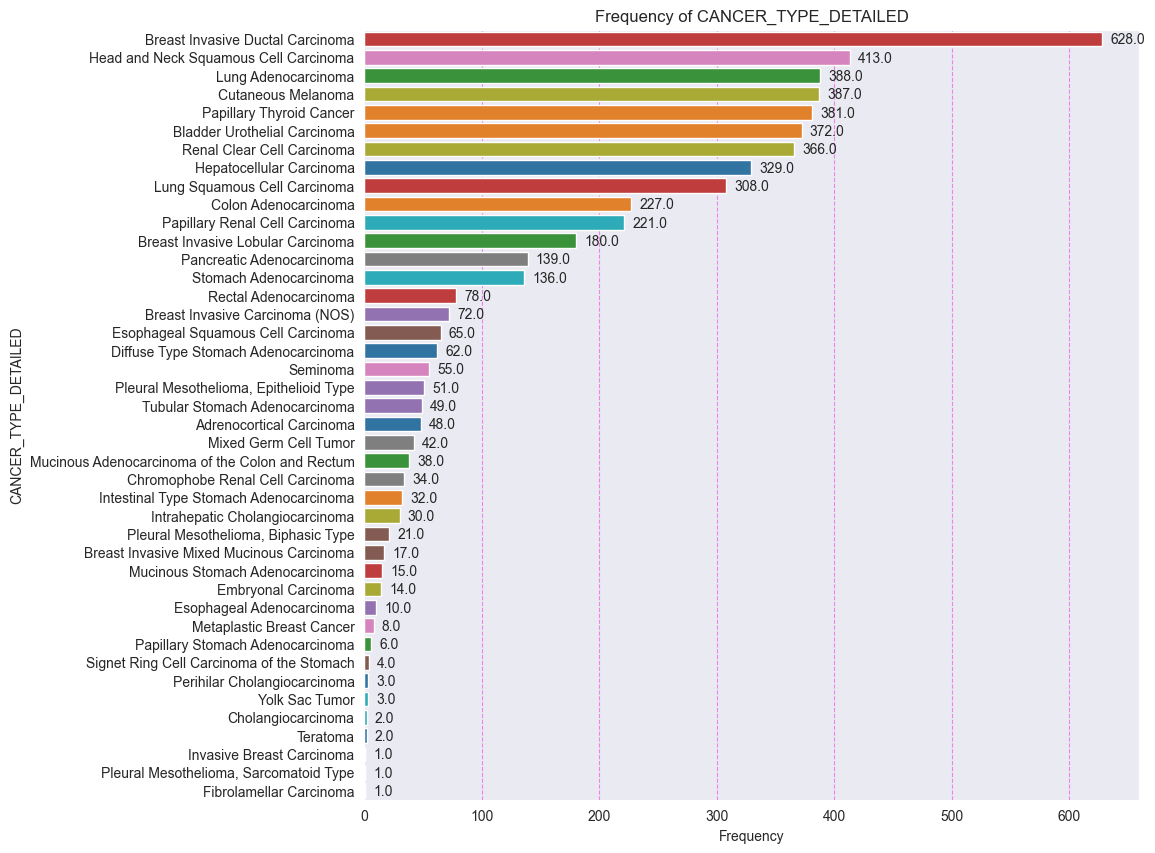

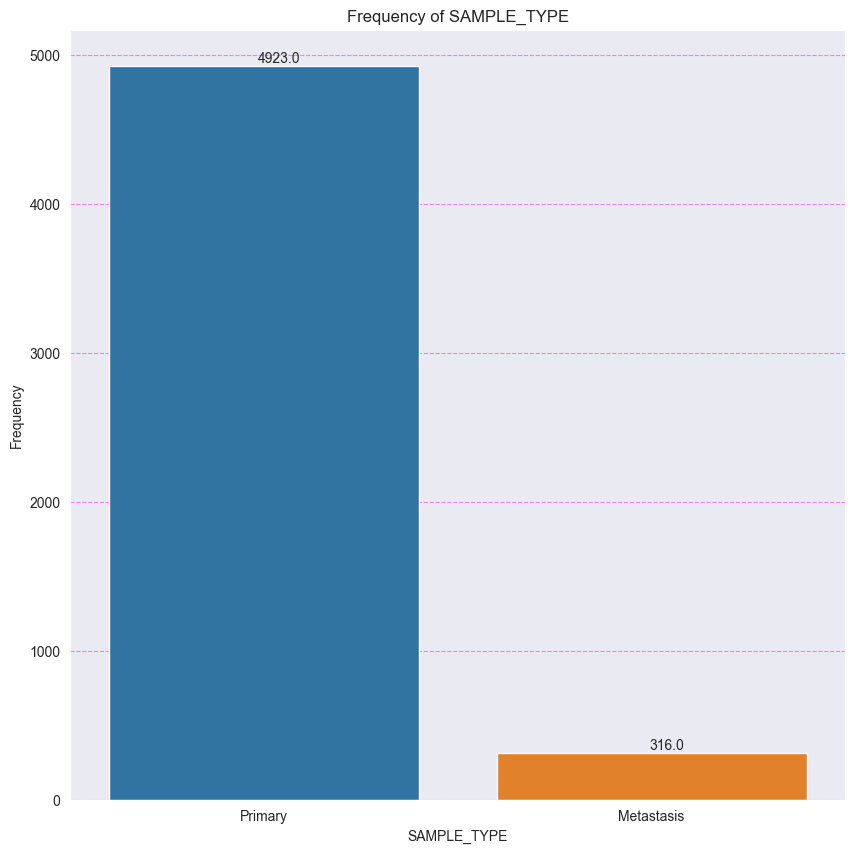

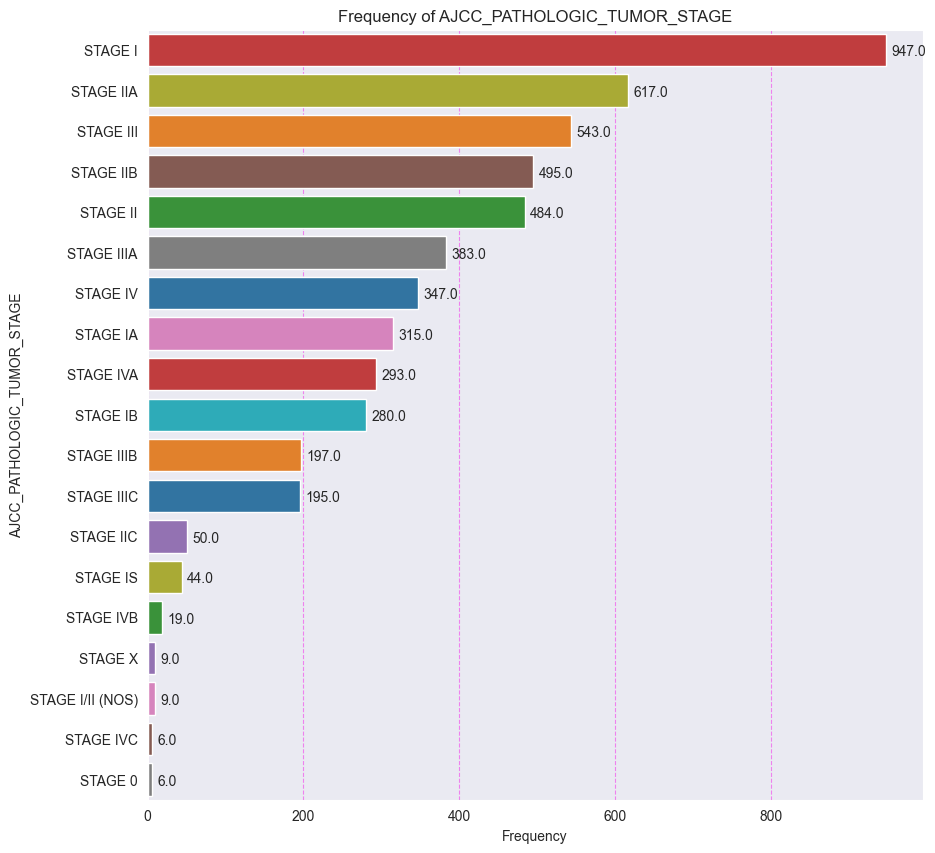

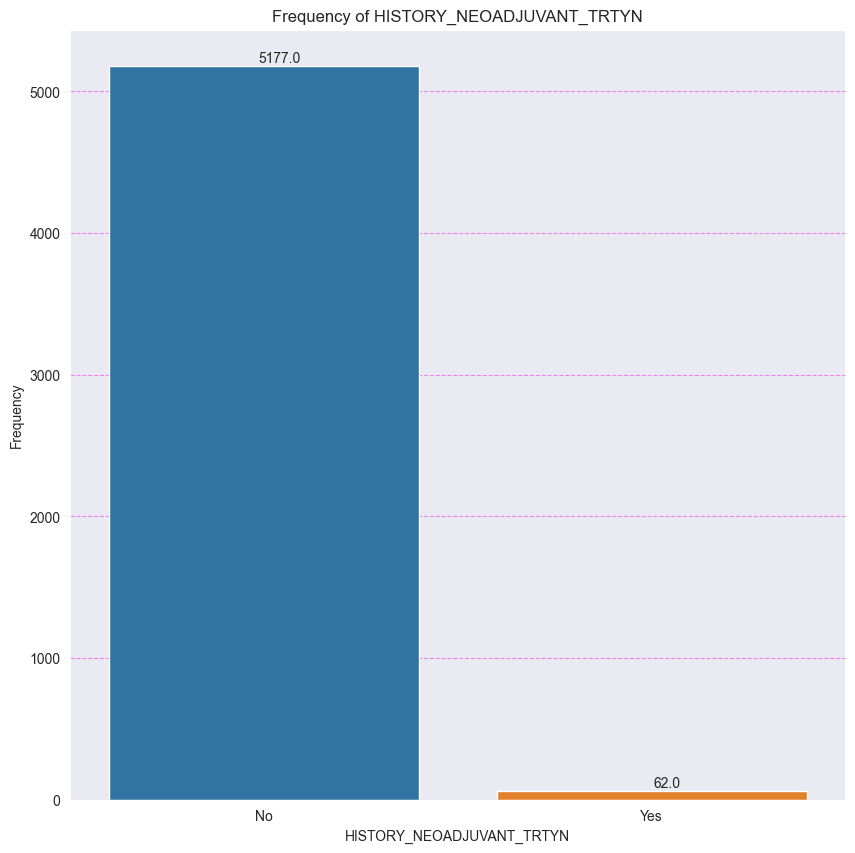

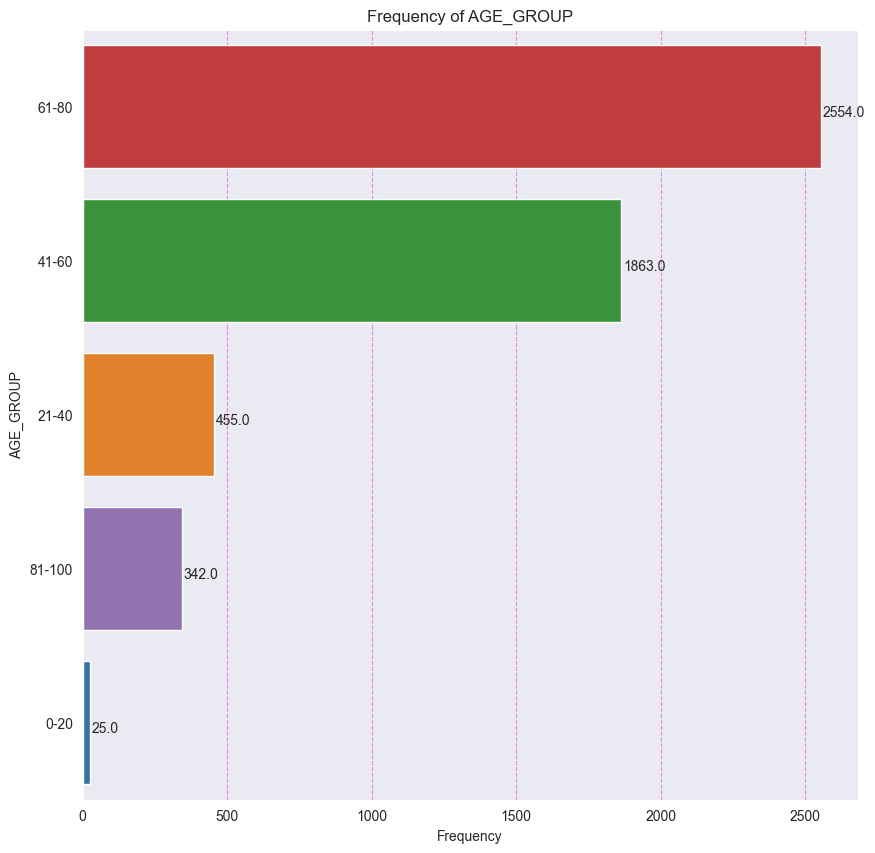

In [25]:
# Add a title to the document
document.add_heading(f"{heading_index}. Tablas de Frecuencias y gráficos", 1)
heading_index += 1
# For each categorical column, create a frequency table and save it to a word document
for col in categorical_columns:
    document.add_paragraph(f"Variable {col}\n", style="Heading 2")
    table = pd.DataFrame(dataset[col].value_counts().sort_index())
    table.columns = ['F_ABS']
    table['F_ABS_AC'] = table['F_ABS'].cumsum()
    # Add the relative frequency and percentage columns
    table['F_REL'] = round(table['F_ABS']/(table['F_ABS'].sum()), 4)
    table['F_REL_AC'] = round(table['F_REL'].cumsum(), 4)
    table['%'] = round(table['F_REL']*100,2)
    table['%_AC'] = round(table['%'].cumsum(), 2)


    # Add the table to the document
    dataframe2table(document, file_name, table, style_table, col)

    order_cat = dataset[col].value_counts().index
    table = table.reindex(order_cat)

    # Create a bar plot with the frequency of the categories
    plt.figure(figsize=(10,10))

    # If number of categories is greater than 5, then plot a barh plot
    if len(order_cat) > 4:
        graph = sns.countplot(data=dataset, y=col, order=order_cat, palette='tab10', hue=col)
        plt.xlabel('Frequency')
        plt.ylabel(col)
        # Plot the frequency on top of the bars (number of cases)
        for p in graph.patches:
            plt.text(7 + p.get_width(), p.get_y() + 0.55*p.get_height(),'{}'.format(p.get_width()), ha='left', va='center')
    else:
        graph = sns.countplot(data=dataset, x=col, order=order_cat, palette='tab10', hue=col)
        plt.ylabel('Frequency')
        plt.xlabel(col)
        # Plot the frequency on top of the bars
        for p in graph.patches:
            plt.text(p.get_x() + 0.55*p.get_width(), 5+p.get_height(),'{}'.format(p.get_height()), ha='center', va='bottom')

    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=0)

    # Save the plot to a file
    plt.savefig(f'plots/plot_{col}.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    # Save the plot to the word document
    plot2doc(document, file_name, f'plots/plot_{col}.png')

document.save(file_name)

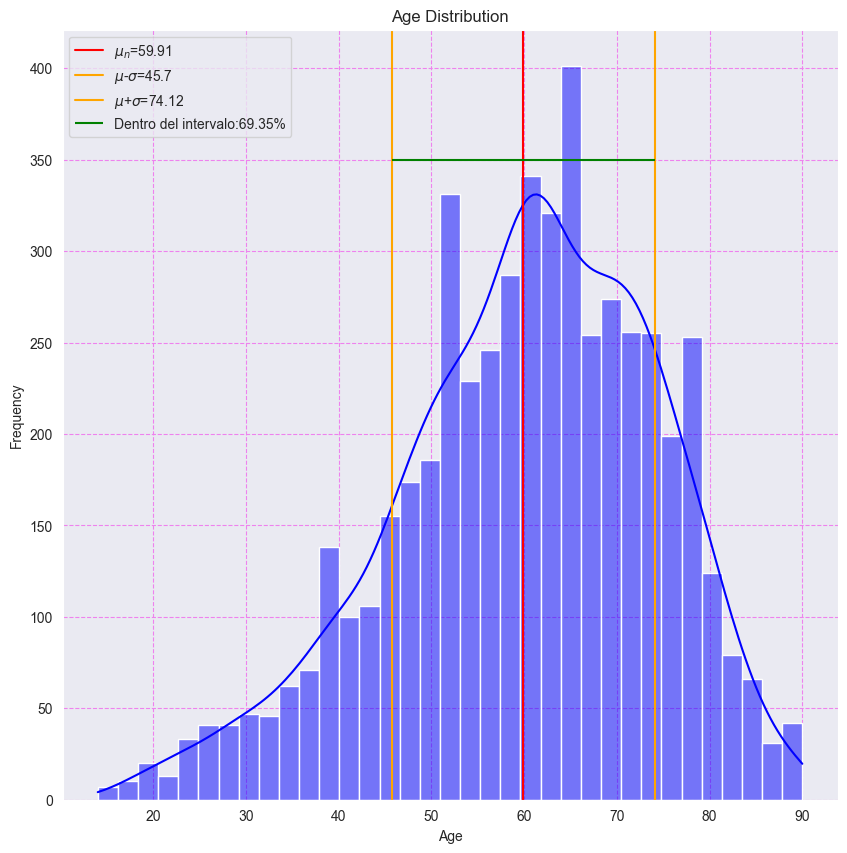

In [26]:
# Histogram of the age of the patients
summary_age = dataset['AGE'].describe()
# Calcular el intervalo de dispersion a una desviacion estandar
std_min = round(summary_age['mean'] - summary_age['std'], 2)
std_max = round(summary_age['mean'] + summary_age['std'], 2)
interval = round(dataset['AGE'][(dataset['AGE']>std_min) & (dataset['AGE']<std_max)].count()/len(dataset['AGE'])*100, 2)

# Add a title to the document
document.add_heading("2. Histograma de la Edad", 1)
document.add_paragraph("La variable tiene un rango de valores entre " + str(summary_age['min']) + " y " + str(summary_age['max']) + ".")
document.add_paragraph("La media es " + str(round(summary_age['mean'], 2)) + " y la mediana es " + str(summary_age['50%']) + ".")
document.add_paragraph("La desviación estándar es " + str(round(summary_age['std'], 2)) +
                        ". El intervalo de dispersión a una desviación estándar es " + str(std_min) + " - " + str(std_max) + " y contiene el " + str(interval) + "% de los datos.")
document.add_paragraph("El rango intercuartílico es " + str(summary_age['25%']) + " - " + str(summary_age['75%']) + ".")
document.add_paragraph("")

# Create the histogram
plt.figure(figsize = [10, 10])
sns.histplot(dataset['AGE'].dropna(), kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Add the mean to the plot
plt.axvline(x=summary_age['mean'], color="red", label=f"$\mu_n$={round(summary_age['mean'], 2)}")
plt.axvline(x=std_min,color="orange",label=f"$\mu$-$\sigma$={std_min}")
plt.axvline(x=std_max,color="orange",label=f"$\mu$+$\sigma$={std_max}")
plt.hlines(y=350, xmin=std_min, xmax=std_max, color='green', label=f"Dentro del intervalo:{interval}%")
plt.legend()

plt.savefig('plots/age_distribution.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Save the plot to the word document
plot2doc(document, file_name, 'plots/age_distribution.png')

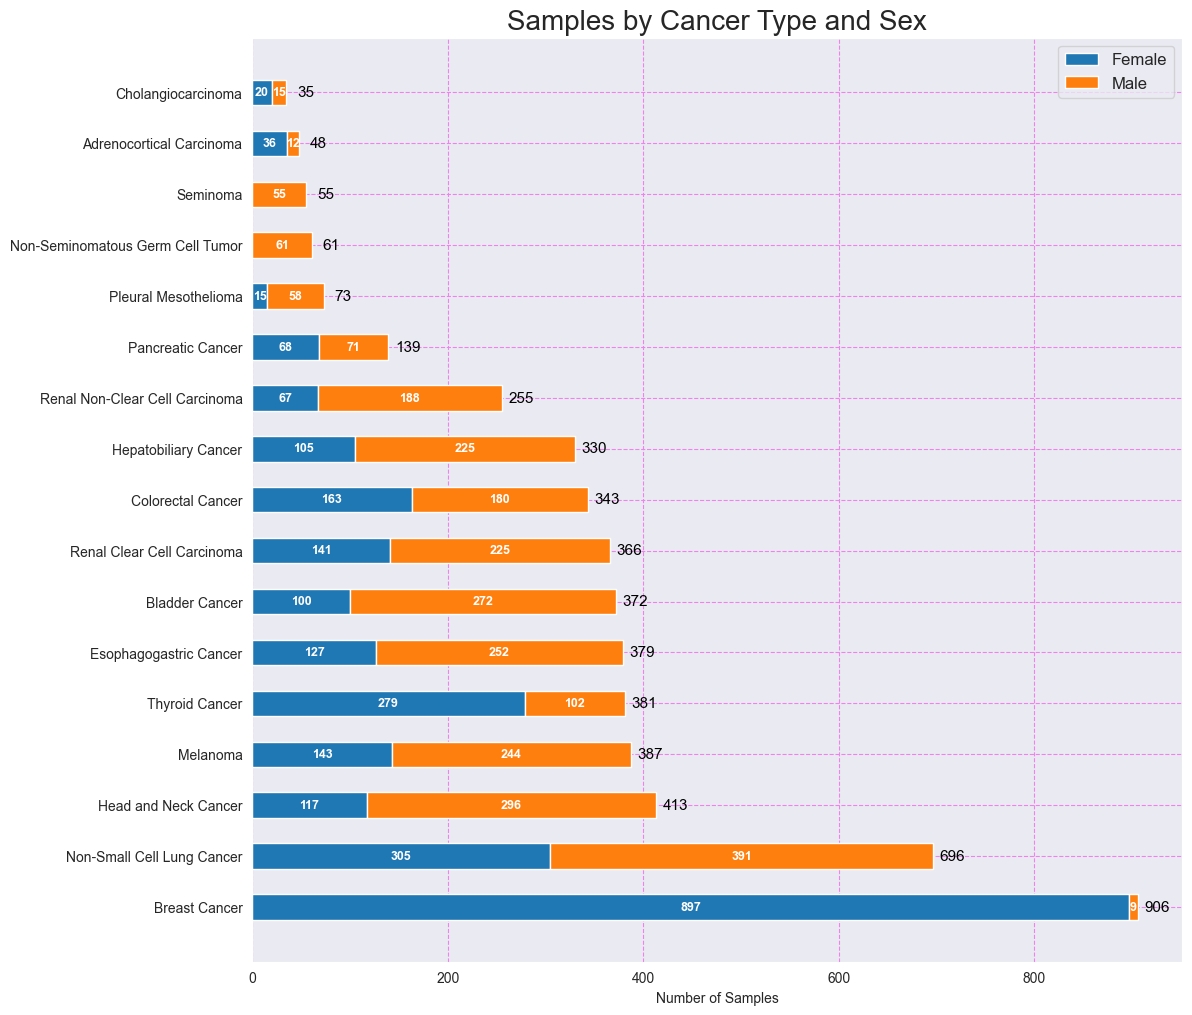

In [27]:
# Create a crosstab with the samples per sex and cancer type
sex_tumor = pd.crosstab(
    index = dataset['CANCER_TYPE'],
    columns = dataset['SEX']
)

# Total value of every column
total_count = sex_tumor.sum(axis=1).sort_values(ascending=False)

# Order the rows by the total value
index_order = total_count.index
# Reorder the rows of the table
sex_tumor = sex_tumor.reindex(index_order, axis=0)

# Save the table to the document
document.add_heading(f"{heading_index}. Tabla de Frecuencias por Sexo y Tipo de Cáncer", 1)
heading_index += 1
dataframe2table(document, file_name, sex_tumor, style_table, 'CANCER_TYPE')
document.add_paragraph("")

# Barh plot with the samples per sex and cancer type
fig, ax = plt.subplots()
fig.set_size_inches(12,12)

# Define a list of colors for the bars
colors = ['tab:blue', 'tab:orange']

# Define the order for ther columns
col_order = ['Female', 'Male']

# Initialize the left position for each bar
left = [0] * len(sex_tumor.index)

# Iterate through the columns in sex_tumor and plot the bars
for col, color in zip(col_order, colors):
    values = sex_tumor[col]
    ax.barh(sex_tumor.index, values, left=left, label=col, height=0.5, color=color)
    
    # Add labels only for non-zero bars
    for idx, val in enumerate(values):
        if val != 0:
            ax.text(left[idx] + val / 2, idx, str(val), ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    
    # Update the left position for the next set of bars
    left = [left_val + val for left_val, val in zip(left, values)]

# Add the total value of every column
for idx, total in enumerate(total_count):
    ax.text(total + 20, idx, str(total), ha='center', va='center', color='black', fontsize=11)


ax.set_title('Samples by Cancer Type and Sex', fontsize=20)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Number of Samples')
# Save the plot to a file
plt.savefig('plots/samplesPerSexCancerType.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Save the plot to the word document
plot2doc(document, file_name, 'plots/samplesPerSexCancerType.png')

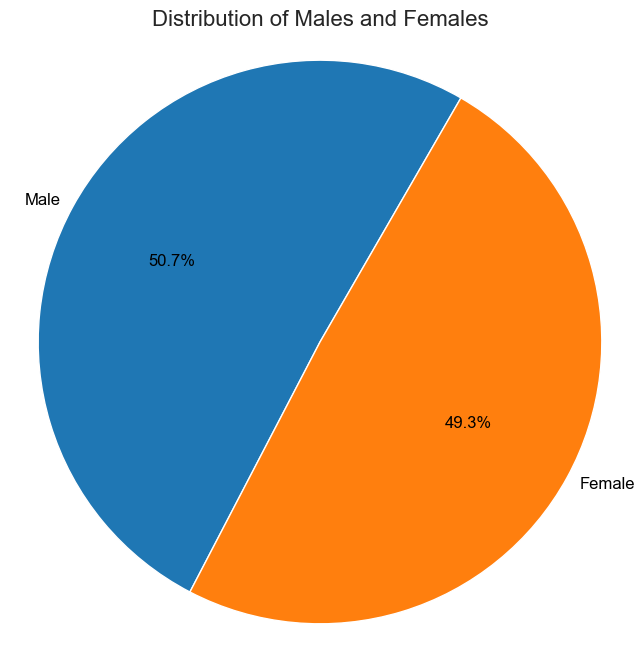

In [28]:
# Pie chart with sex distribution
sex_counts = dataset['SEX'].value_counts(dropna=False)

# Save the table to the document
document.add_heading(f"{heading_index}. Distribución de Sexos", 1)
heading_index += 1
dataframe2table(document, file_name, sex_counts.to_frame(), style_table, 'SEX')

# Create a pie chart
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

# Plot the pie chart
ax.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=60, labeldistance=1.05, textprops={'fontsize': 12, 'color': 'black'}, colors=['tab:blue', 'tab:orange'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title('Distribution of Males and Females', fontsize=16)

# Save the plot to a file
plt.savefig('plots/SexDistribution.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Save the plot to the word document
plot2doc(document, file_name, 'plots/SexDistribution.png')

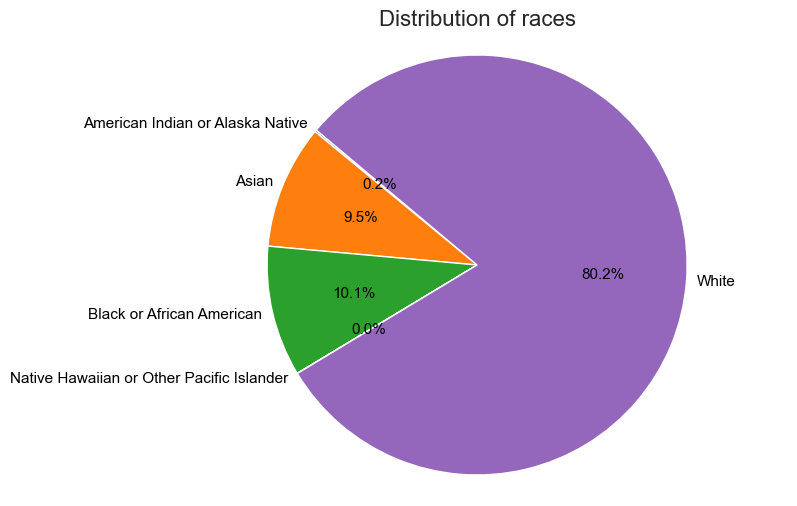

In [29]:
# Pie chart with race distribution
race_counts = dataset['RACE'].value_counts(dropna=False)
race_counts.sort_index(inplace=True)

# Save the table to the document
document.add_heading(f"{heading_index}. Distribución de Razas", 1)
heading_index += 1
dataframe2table(document, file_name, race_counts.to_frame(), style_table, 'RACE')

# Create a pie chart
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# Plot the pie chart
ax.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140, labeldistance=1.05, textprops={'fontsize': 11, 'color': 'black'}, colors=sns.color_palette('tab10'))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax.set_title('Distribution of races', fontsize=16)

# Save the plot to a file
plt.savefig('plots/RaceDistribution.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Save the plot to the word document
plot2doc(document, file_name, 'plots/RaceDistribution.png', w=6 ,h=4)

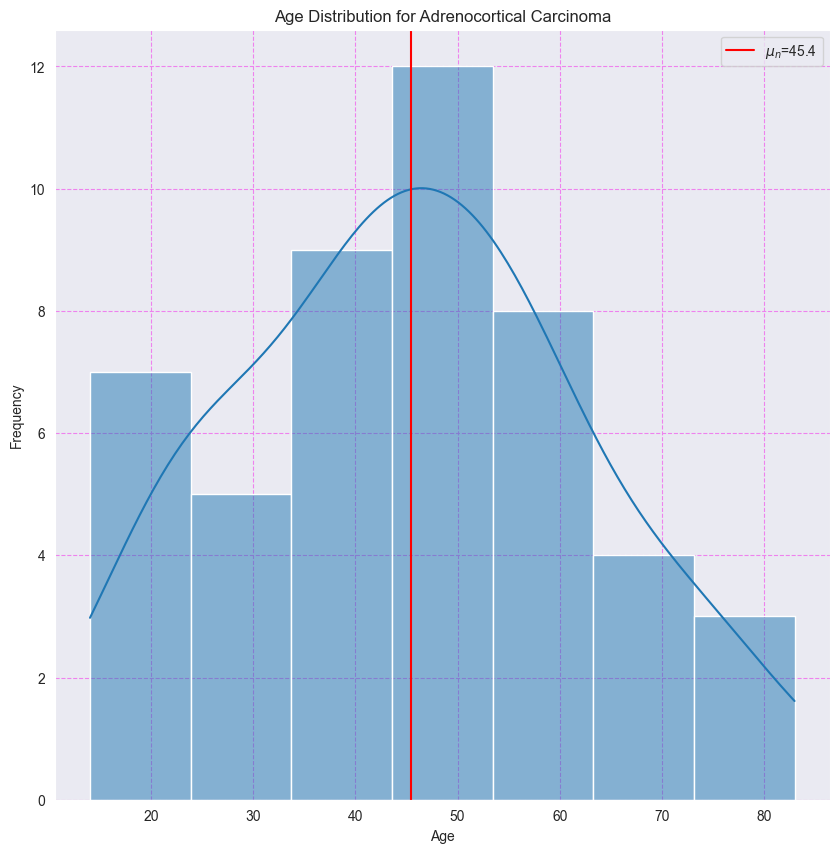

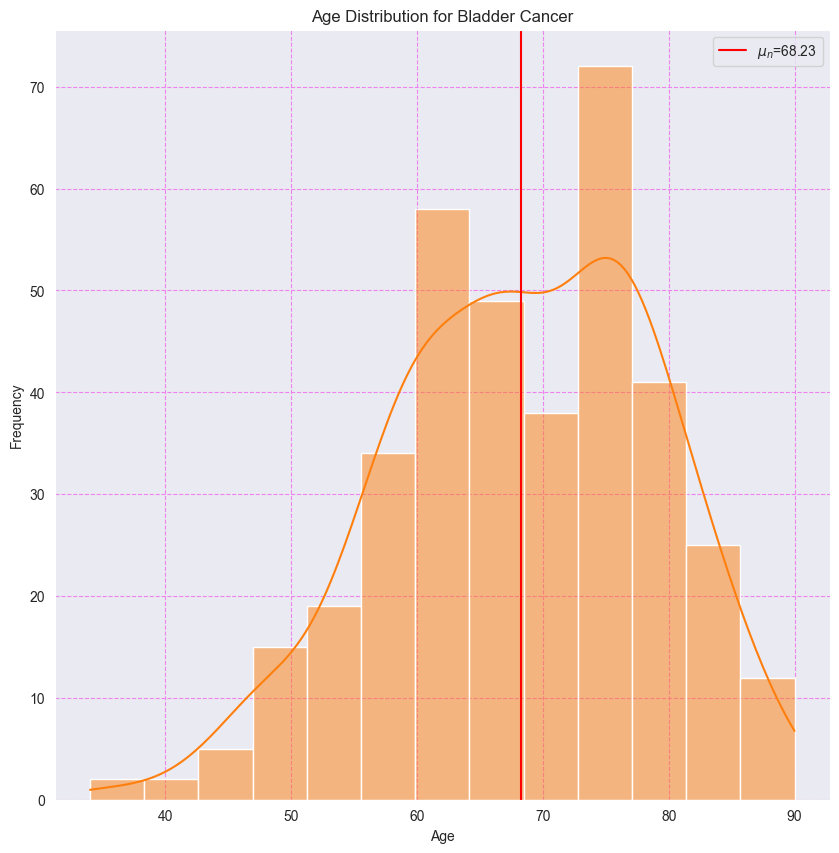

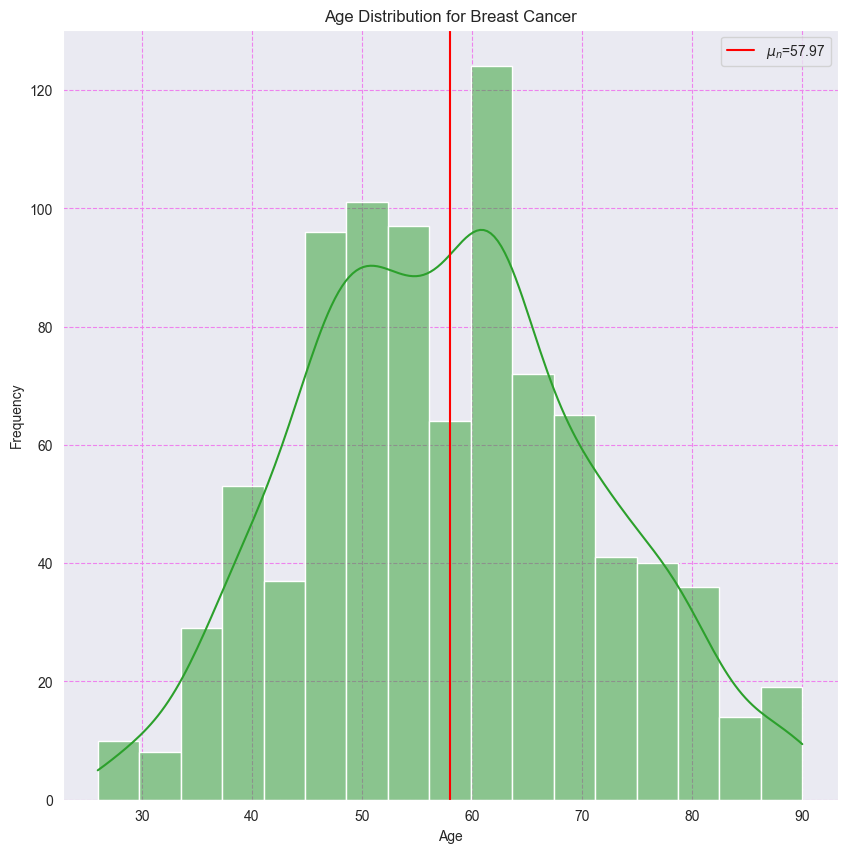

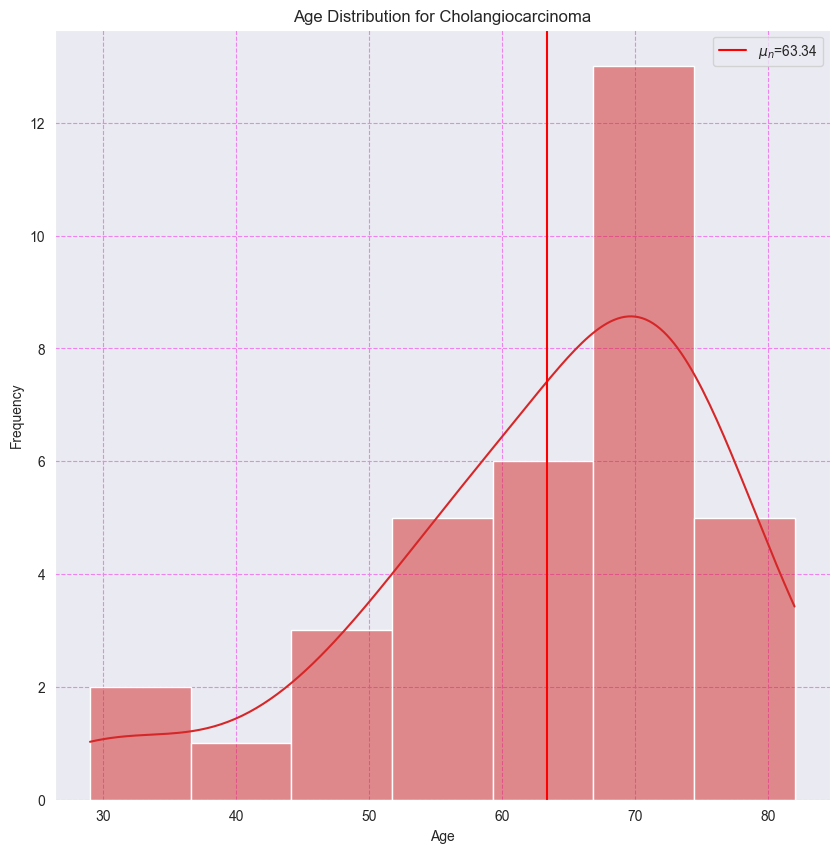

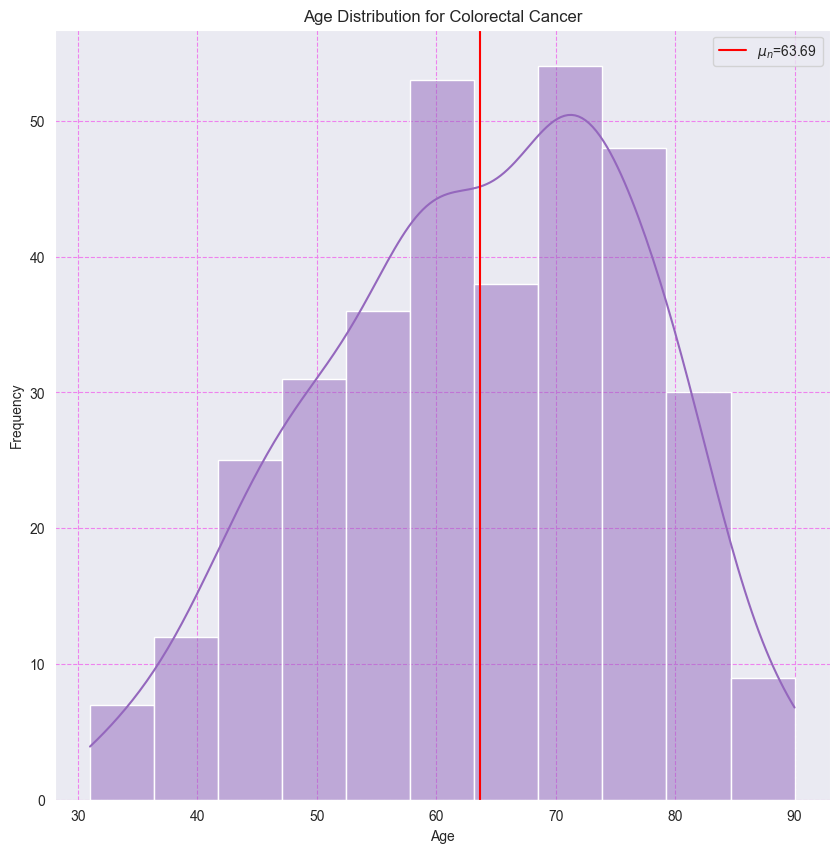

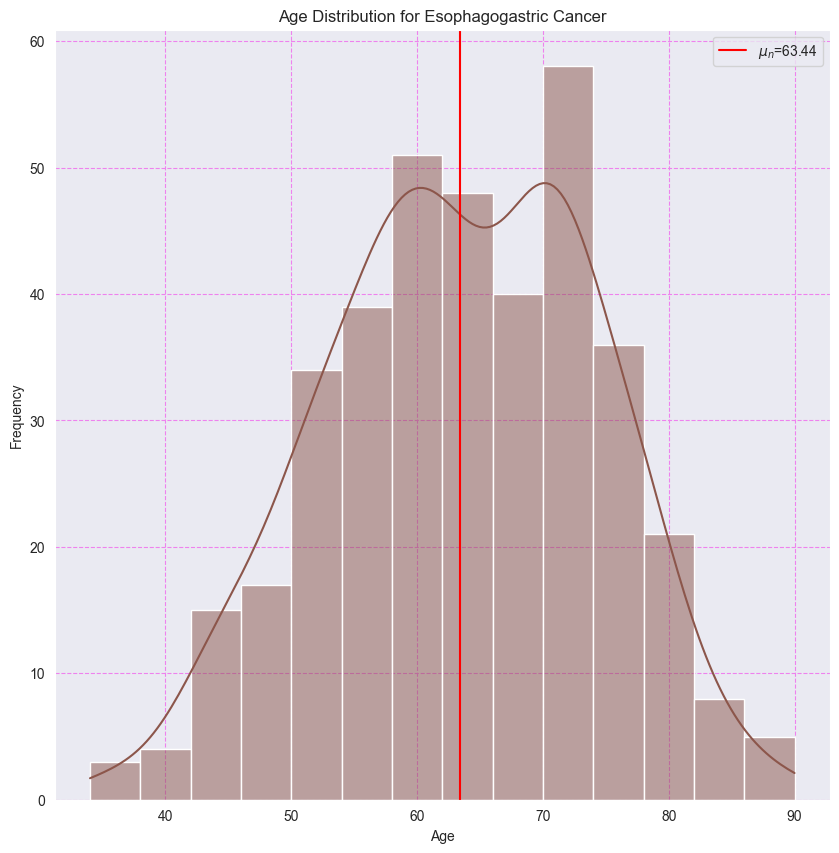

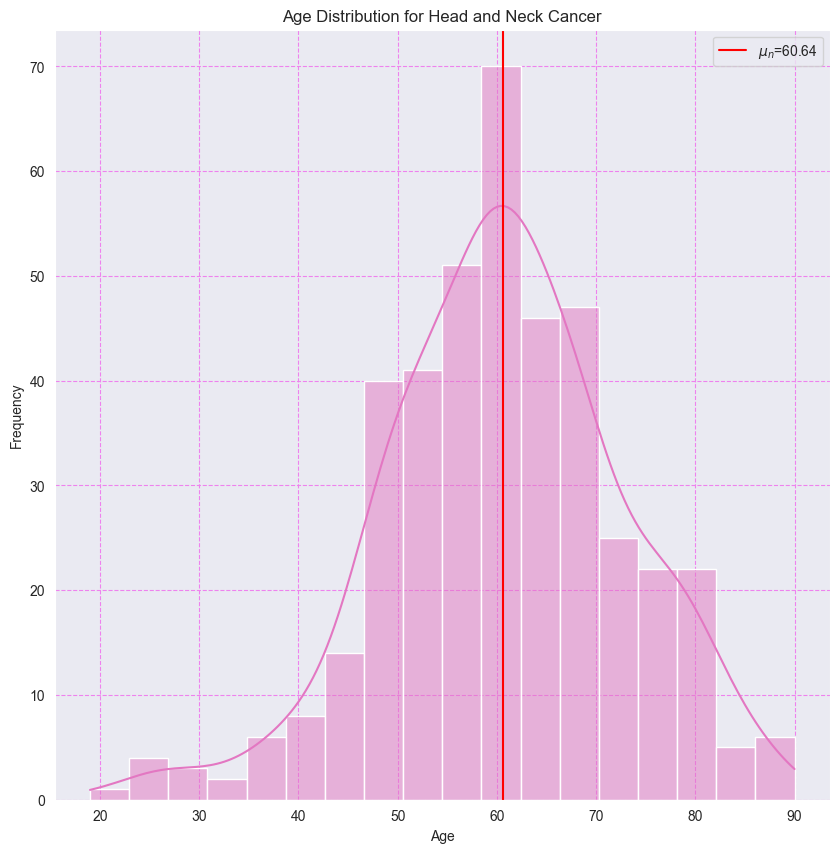

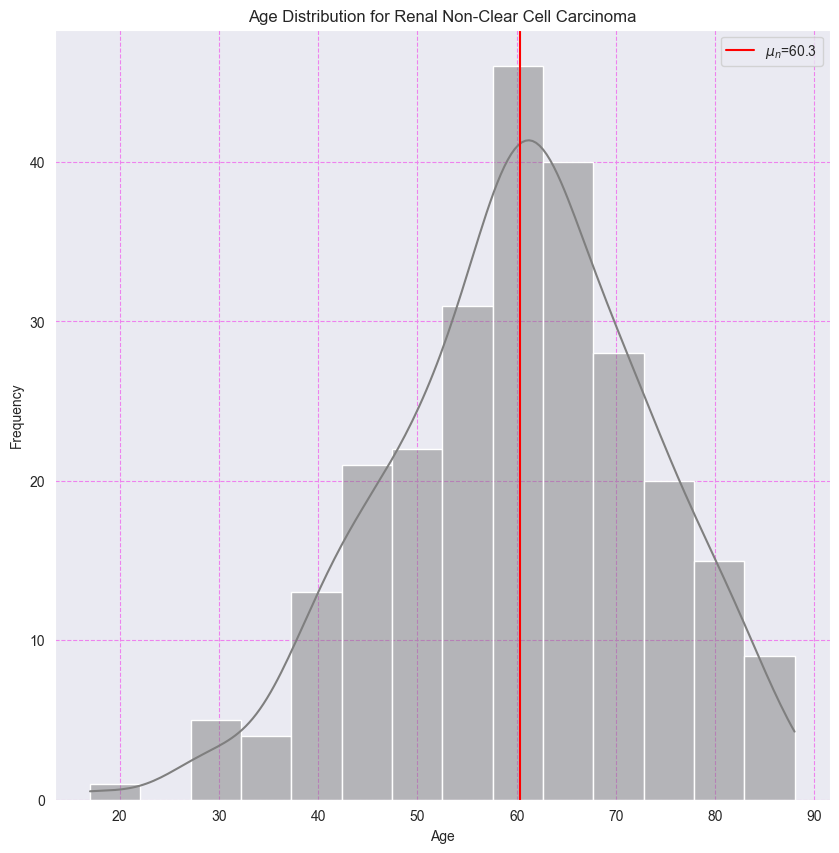

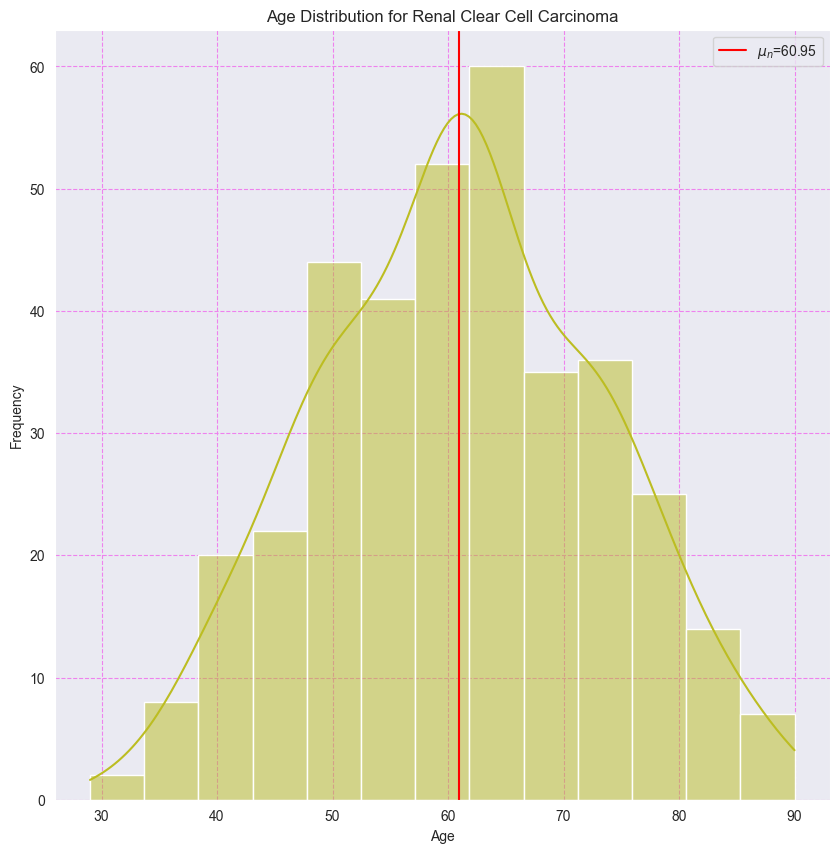

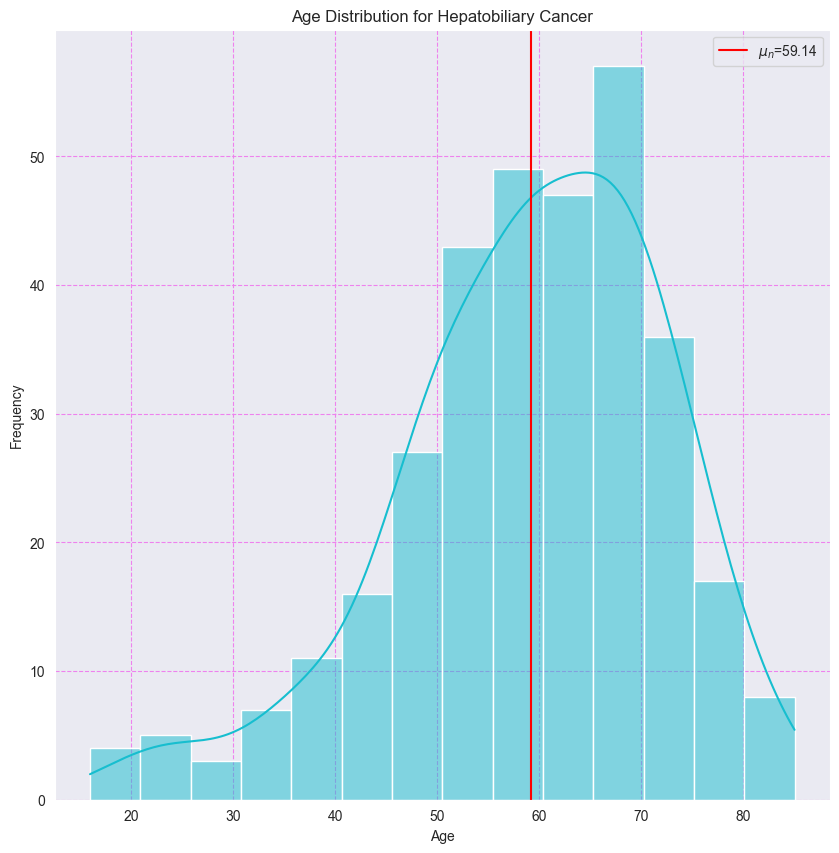

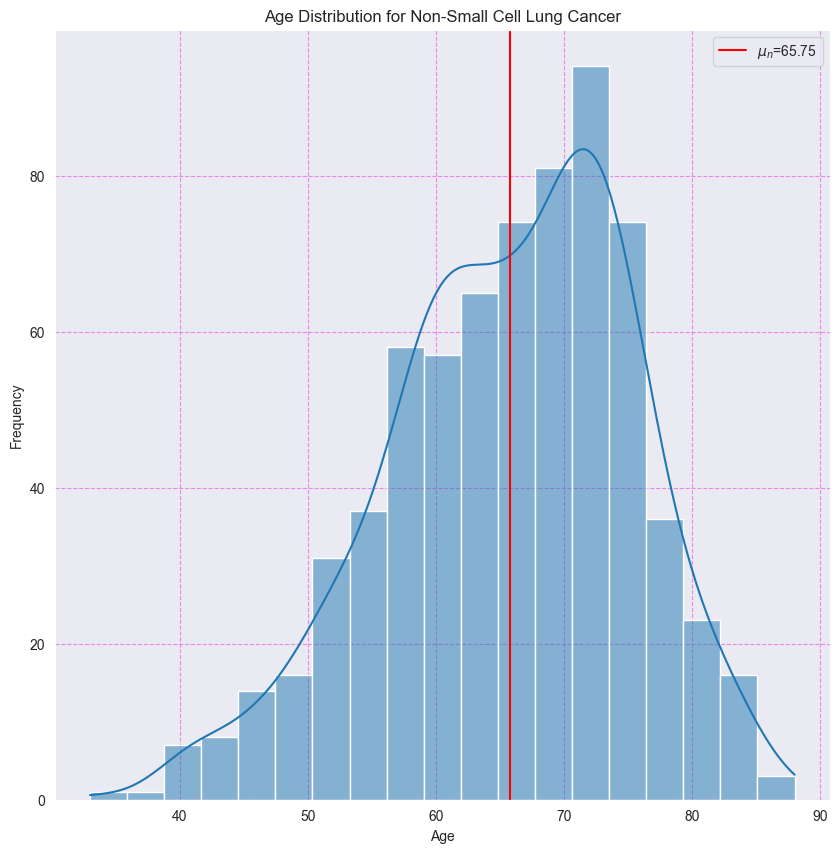

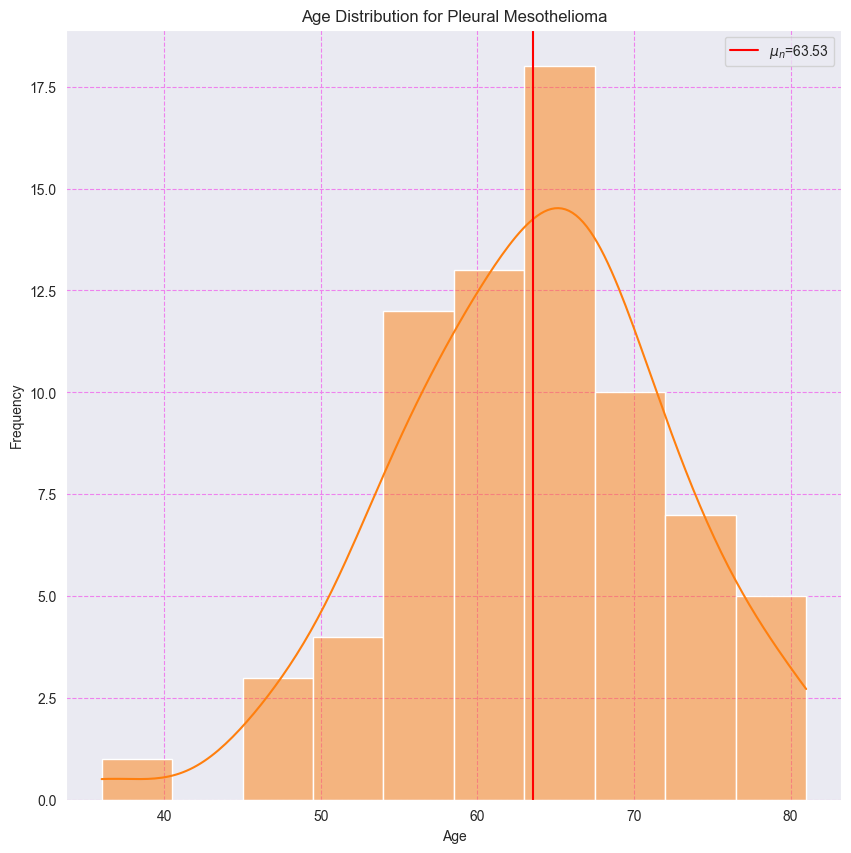

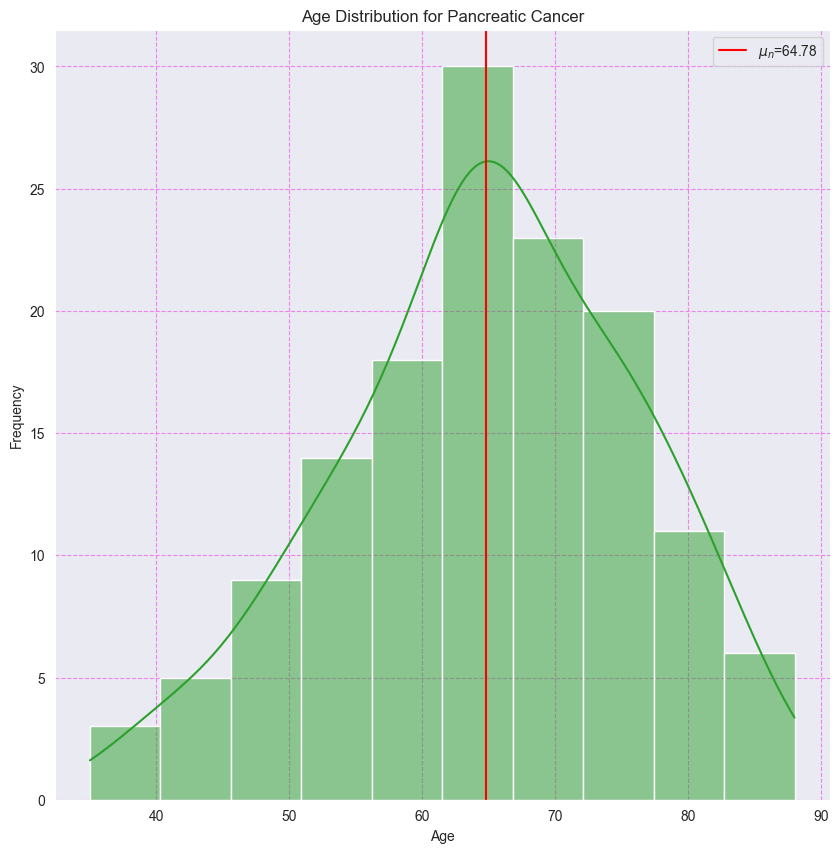

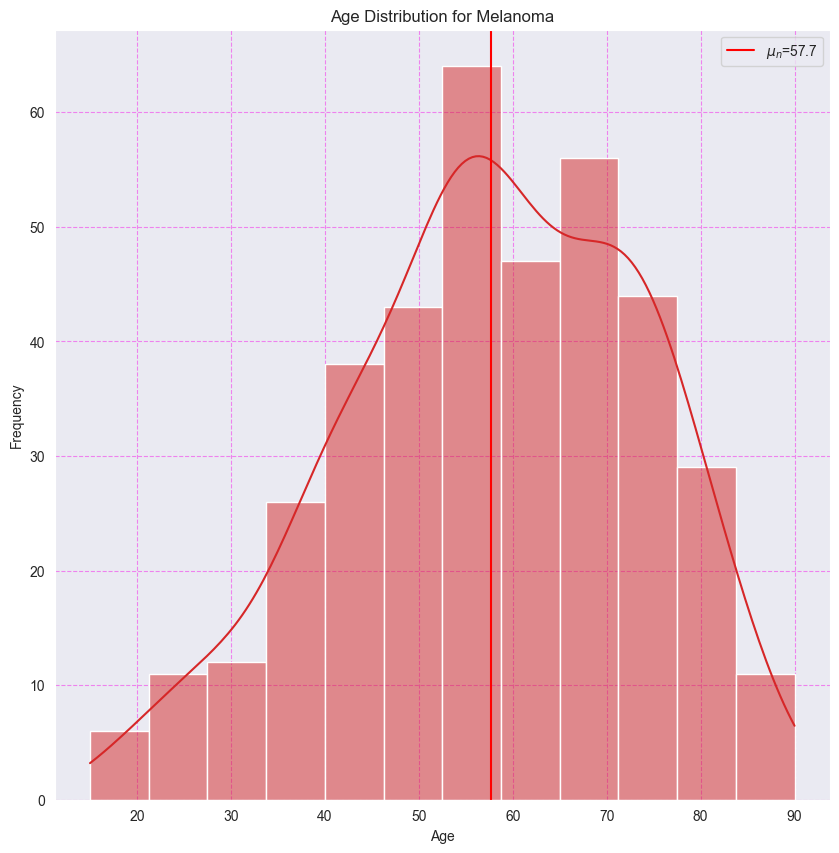

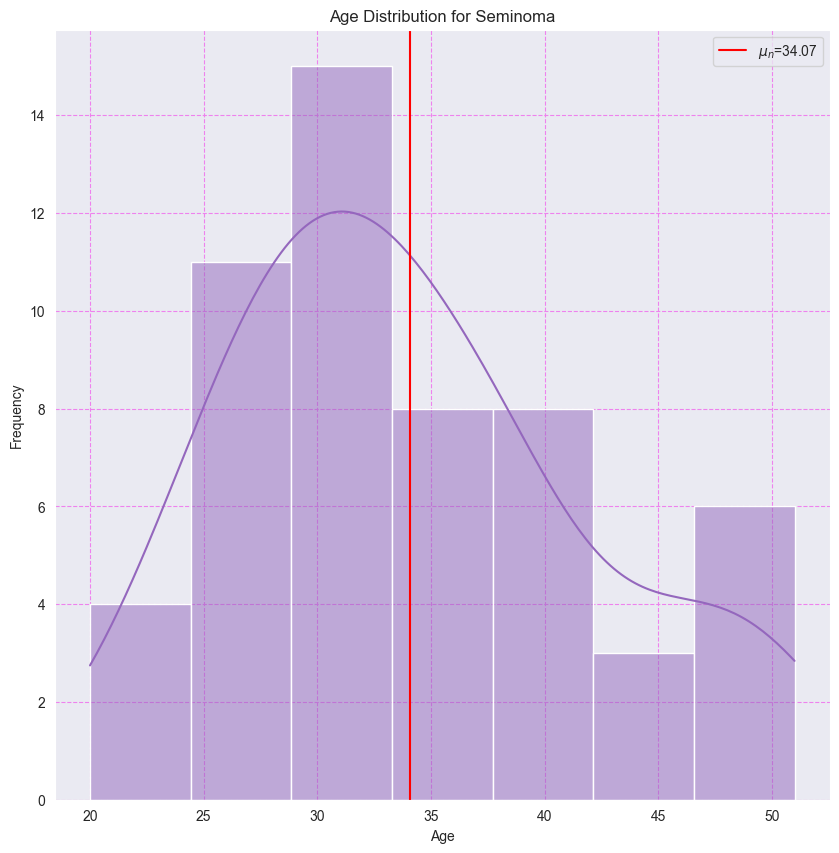

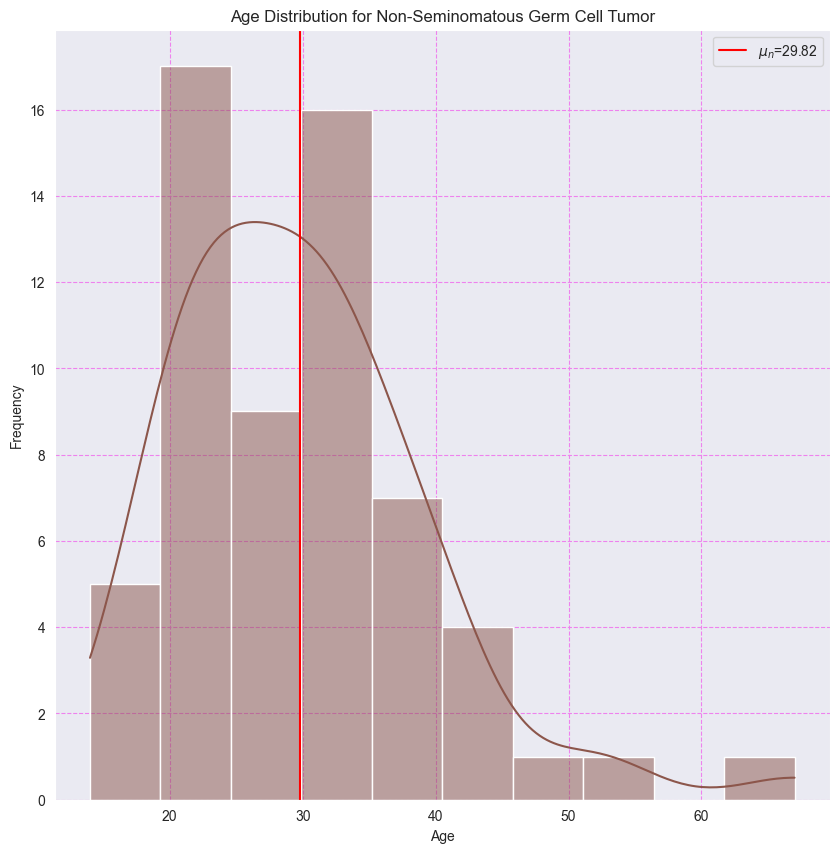

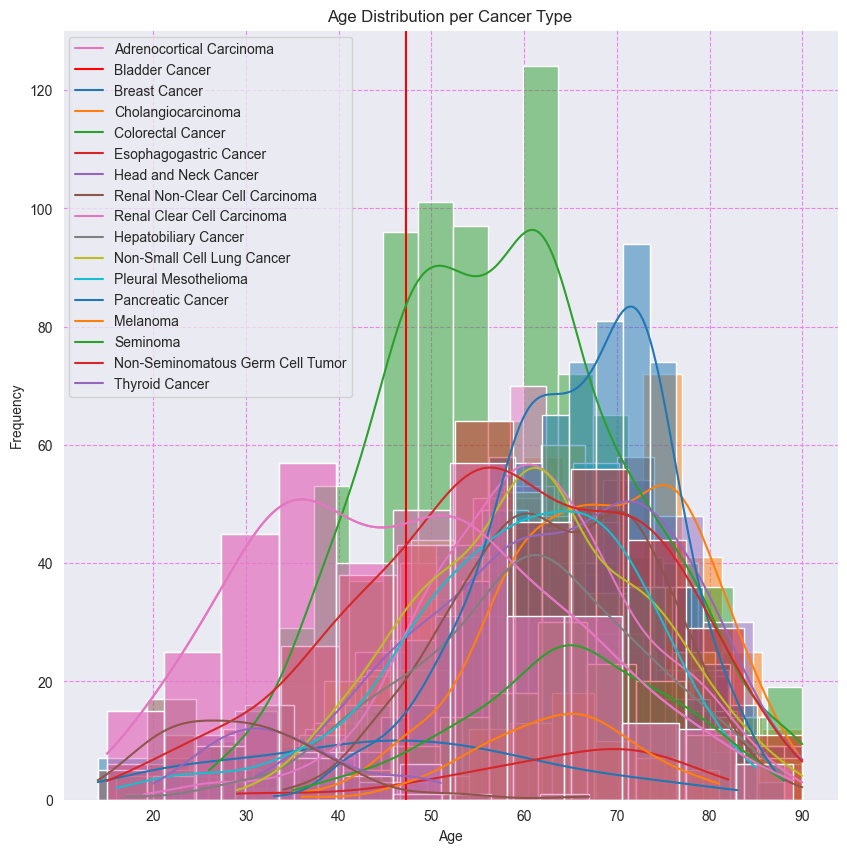

In [30]:
# Histogram per cancer type. Age distribution per cancer type
# Get a list of the unique cancer types
cancer_types = dataset['CANCER_TYPE'].unique()

# Get a colour palette with the same number of colours as cancer types
palette = sns.color_palette('tab10', n_colors=len(cancer_types))

document.add_heading(f"{heading_index}. Histogramas de Edades por Tipo de Cáncer", 1)
heading_index += 1

i = 1

# Create a histogram for each cancer type
for cancer in cancer_types:
    # Filter the dataset by the cancer type
    subset = dataset[dataset['CANCER_TYPE'] == cancer]
    # Create the histogram
    plt.figure(figsize = [10, 10])
    sns.histplot(subset['AGE'].dropna(), kde=True, color=palette[cancer_types.tolist().index(cancer)])
    # Add the mean to the plot
    plt.axvline(x=subset['AGE'].mean(), color="red", label=f"$\mu_n$={round(subset['AGE'].mean(), 2)}")
    plt.title(f'Age Distribution for {cancer}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'plots/age_distribution_{cancer}.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    # Create new heading
    document.add_heading(f"{i}. Histograma de Edades para {cancer}", 2)
    # Save the plot to the word document
    plot2doc(document, file_name, f'plots/age_distribution_{cancer}.png')
    i += 1

# Now merge all the plots
for cancer in cancer_types:
    # Filter the dataset by the cancer type
    subset = dataset[dataset['CANCER_TYPE'] == cancer]
    sns.histplot(subset['AGE'].dropna(), kde=True, color=palette[cancer_types.tolist().index(cancer)])

plt.title(f'Age Distribution per Cancer Type')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(cancer_types)

plt.savefig('plots/age_distribution_per_cancer.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Add a new heading
document.add_heading(f"{i}. Histograma de Edades por Tipo de Cáncer", 2)
# Save the plot to the word document
plot2doc(document, file_name, 'plots/age_distribution_per_cancer.png')

In [31]:
# Tumor stage distribution per cancer type
# Create a crosstab with the samples per tumor stage and cancer type, removing the missing values
tumor_stage_cancer = pd.crosstab(
    index = dataset['CANCER_TYPE'],
    columns = dataset['AJCC_PATHOLOGIC_TUMOR_STAGE'],
    dropna = True
)

# Fix the name of thr columns removing the spaces and the prefix STAGE
tumor_stage_cancer.columns = [col.replace('STAGE ', '') for col in tumor_stage_cancer.columns]
tumor_stage_cancer.columns = [col.replace(' ', '_') for col in tumor_stage_cancer.columns]

# Total value of every column
total_count = tumor_stage_cancer.sum(axis=1).sort_values(ascending=False)
# Order the rows by the total value
index_order = total_count.index
# Reorder the rows of the table
tumor_stage_cancer = tumor_stage_cancer.reindex(index_order, axis=0)

# Save the table to the document
document.add_heading(f"{heading_index}. Tabla de Frecuencias por Estadio Tumoral y Tipo de Cáncer", 1)
heading_index += 1

dataframe2table(document, file_name, tumor_stage_cancer, style_table, 'CANCER_TYPE')
document.add_paragraph("")

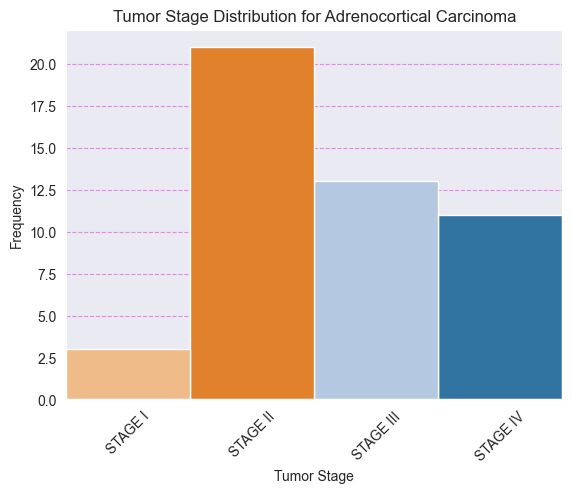

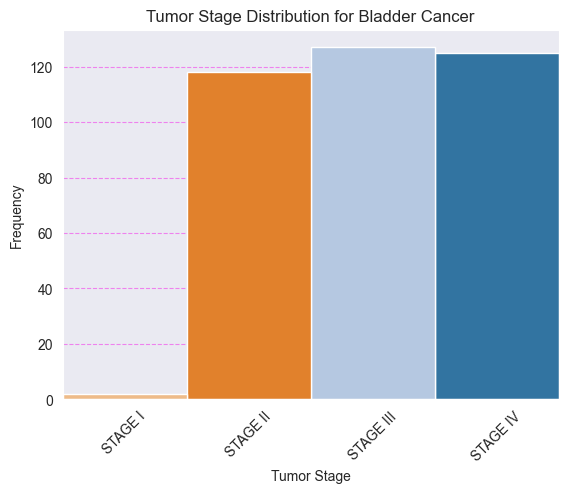

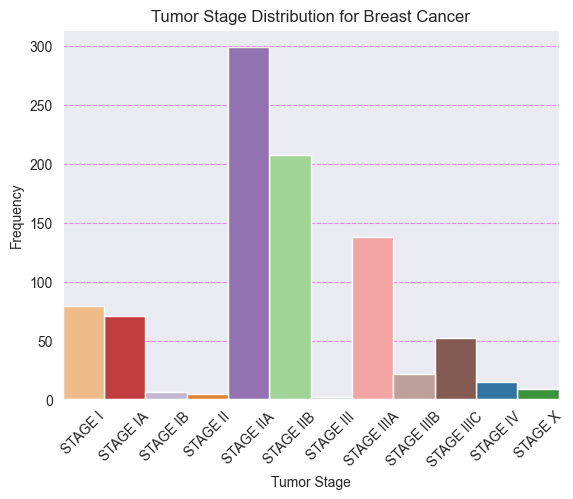

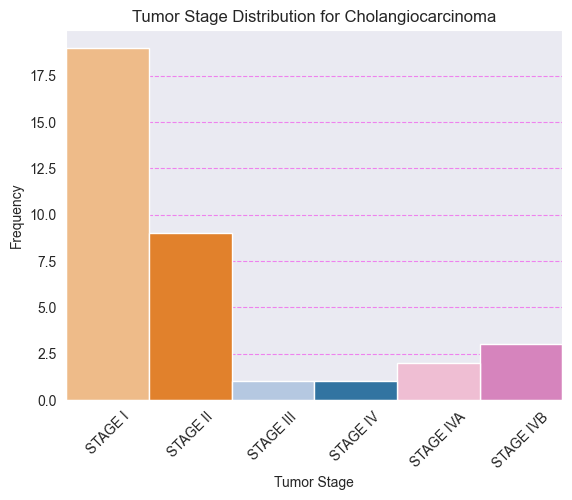

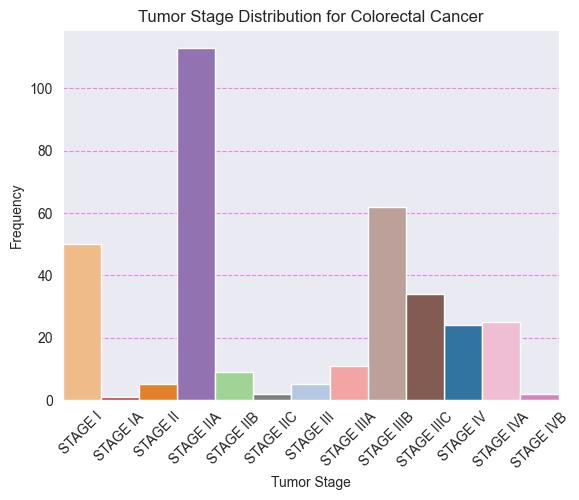

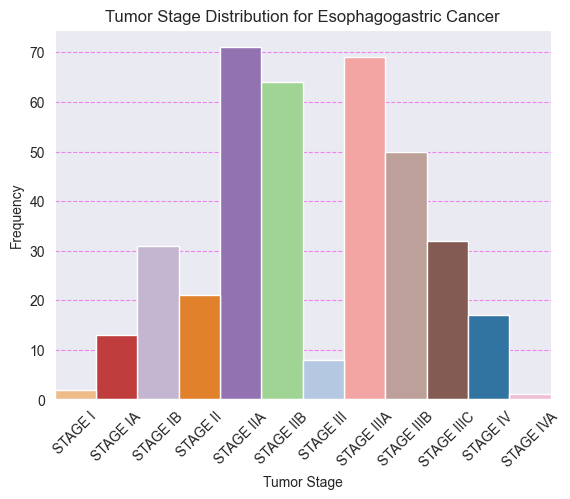

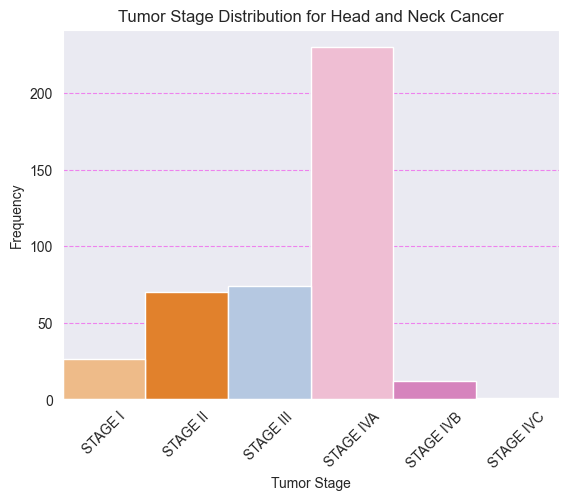

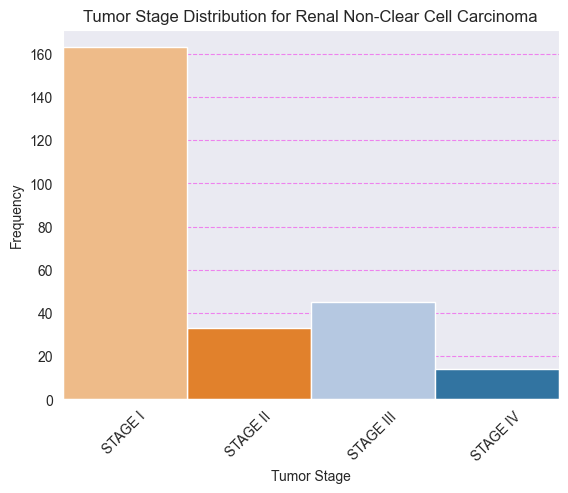

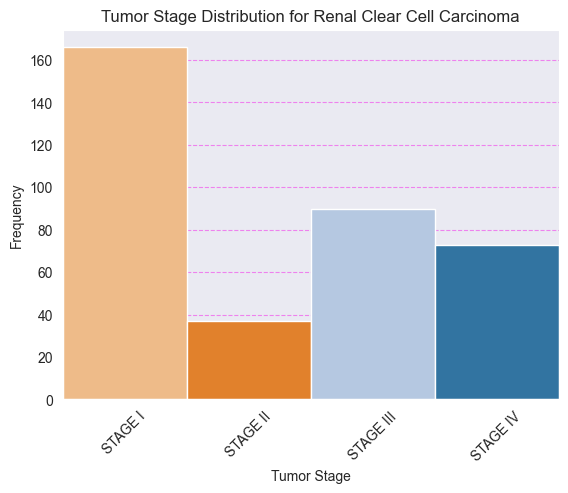

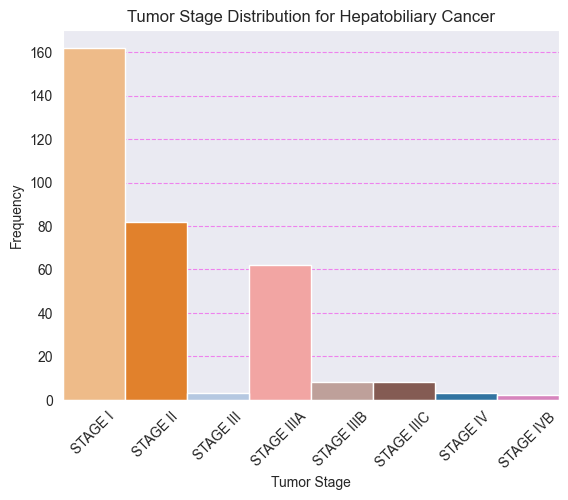

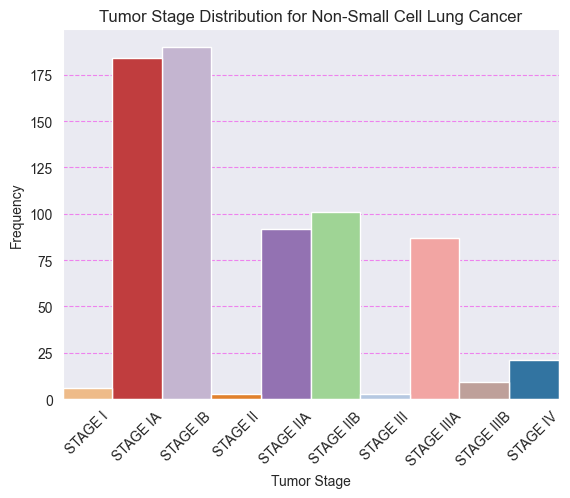

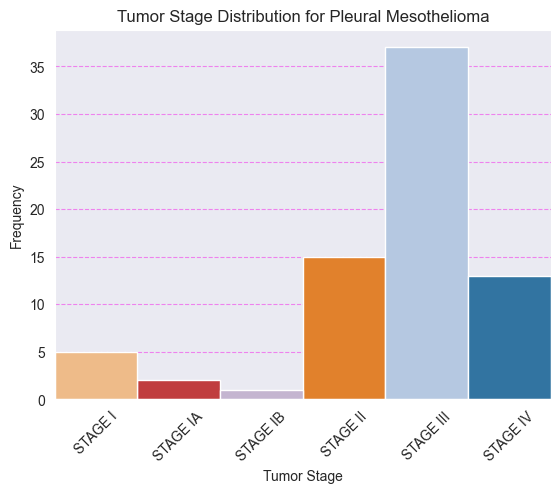

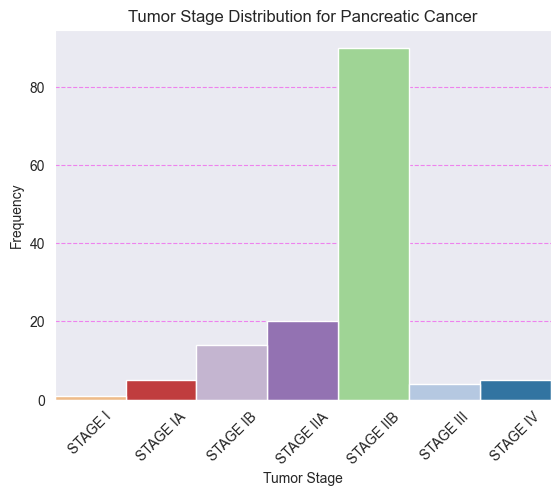

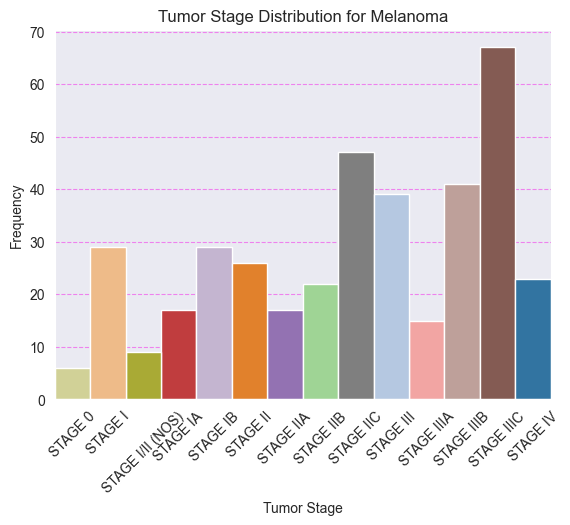

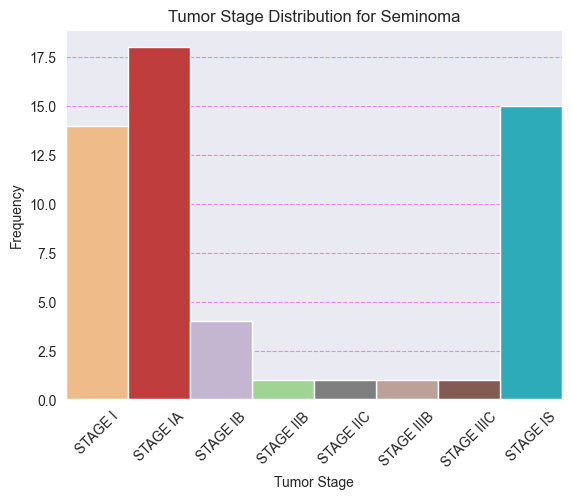

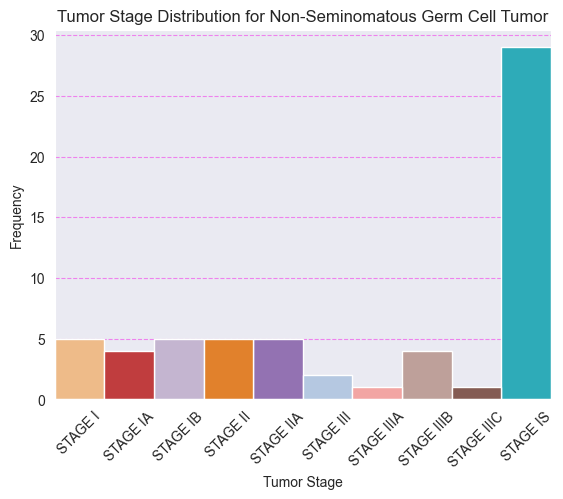

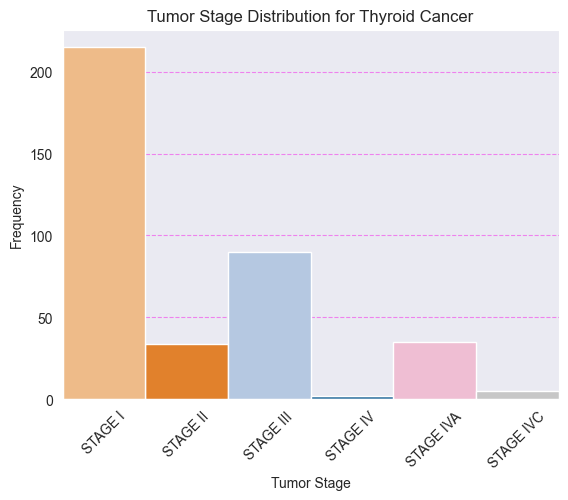

In [32]:
# For each cancer type, create a bar plot with the tumor stage distribution using contiguous bars

# Get the list of cancer types
cancer_types = dataset['CANCER_TYPE'].unique()

# Get the list of tumor stages
tumor_stages = dataset['AJCC_PATHOLOGIC_TUMOR_STAGE'].unique()

# Create a color palette with the same number of colors as tumor stages
palette = sns.color_palette('tab20', n_colors=len(tumor_stages))

# Asign a color to each tumor stage
colors = {tumor: palette[i] for i, tumor in enumerate(tumor_stages)}

document.add_heading(f"{heading_index}. Distribuciones de Estadios Tumorales y Tipo de Cáncer", 1)
heading_index += 1

i = 1
# Iterate through the cancer types
for cancer in cancer_types:
    # Filter the dataset by the cancer type
    subset = dataset[dataset['CANCER_TYPE'] == cancer]

    # Get the tumor stage distribution
    tumor_stage_counts = subset['AJCC_PATHOLOGIC_TUMOR_STAGE'].value_counts().sort_index()

    # Create a bar plot
    plt.figure()
    sns.countplot(data=subset, x='AJCC_PATHOLOGIC_TUMOR_STAGE', order=tumor_stage_counts.index, palette=colors, width=1, hue='AJCC_PATHOLOGIC_TUMOR_STAGE')
    plt.title(f'Tumor Stage Distribution for {cancer}')
    plt.xlabel('Tumor Stage')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    # Save the plot to a file
    plt.savefig(f'plots/tumor_stage_distribution_{cancer}.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    # Add a new heading
    document.add_heading(f"{i}. Distribución de Estadios Tumorales para {cancer}", 2)
    i += 1
    # Save the plot to the word document
    plot2doc(document, file_name, f'plots/tumor_stage_distribution_{cancer}.png')



In [33]:
# Get the unique tumor stages
tumor_stages = dataset['AJCC_PATHOLOGIC_TUMOR_STAGE'].unique()
print(tumor_stages)

['STAGE IV' 'STAGE III' 'STAGE II' 'STAGE I' 'STAGE X' 'STAGE IIB'
 'STAGE IA' 'STAGE IIIA' 'STAGE IIA' 'STAGE IB' 'STAGE IIIC' 'STAGE IIIB'
 'STAGE IVB' 'STAGE IVA' 'STAGE IIC' 'STAGE IVC' 'STAGE I/II (NOS)'
 'STAGE 0' 'STAGE IS']


In [34]:
# Group the tumor stages into 4 groups
# Create a dictionary with the mapping of the tumor stages to the groups
stage_mapping = {
    'STAGE I': 'I',
    'STAGE IA': 'I',
    'STAGE IB': 'I',
    'STAGE II': 'II',
    'STAGE IIA': 'II',
    'STAGE IIB': 'II',
    'STAGE III': 'III',
    'STAGE IIIA': 'III',
    'STAGE IIIB': 'III',
    'STAGE IIIC': 'III',
    'STAGE IV': 'IV',
    'STAGE IVA': 'IV',
    'STAGE IVB': 'IV',
    'STAGE IVC': 'IV',
    'STAGE X': 'X',
    'STAGE 0': '0',
    'STAGE I/II (NOS)': 'I/II',
    'STAGE IS': '0'
}

dataset['TUMOR_STAGE_GROUP'] = dataset['AJCC_PATHOLOGIC_TUMOR_STAGE'].map(stage_mapping)

In [35]:
print(dataset['TUMOR_STAGE_GROUP'].value_counts())

TUMOR_STAGE_GROUP
II      1596
I       1542
III     1318
IV       665
0         50
X          9
I/II       9
Name: count, dtype: int64


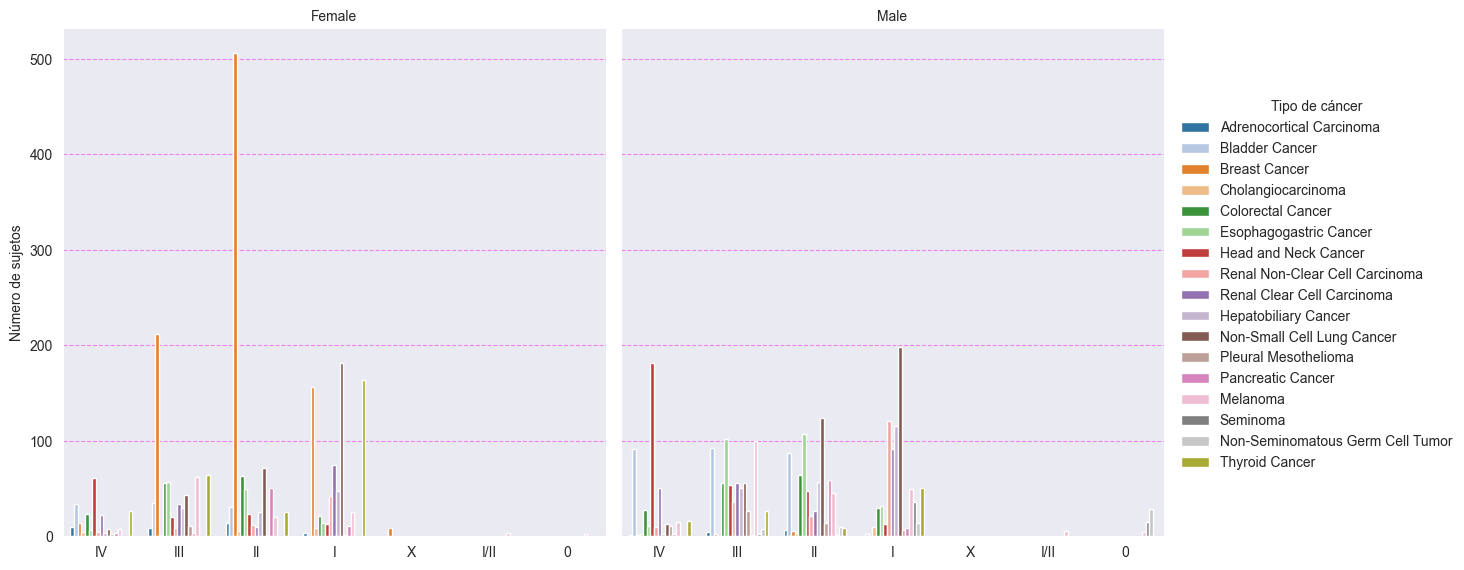

In [36]:
sns.set_style("darkgrid", {"grid.color": "violet", "grid.linestyle": "--"})
# Sex distribution per cancer type and tumor stage
plot = sns.catplot(data=dataset, x='TUMOR_STAGE_GROUP', hue='CANCER_TYPE', col='SEX', kind='count', col_wrap=2, palette='tab20', height=6, aspect=1)
plot.set_titles(template="{col_name}")
plot.set_axis_labels(x_var="", y_var="Número de sujetos")
plot.legend.set_title("Tipo de cáncer")

# Save the plot to a file
plt.savefig('plots/SexDistributionPerCancerTypeTumorStage.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Add a new heading
document.add_heading(f"{heading_index}. Distribución de Sexos por Tipo de Cáncer y Estadio Tumoral", 1)
heading_index += 1
# Save the plot to the word document
plot2doc(document, file_name, 'plots/SexDistributionPerCancerTypeTumorStage.png', w=6, h=4)

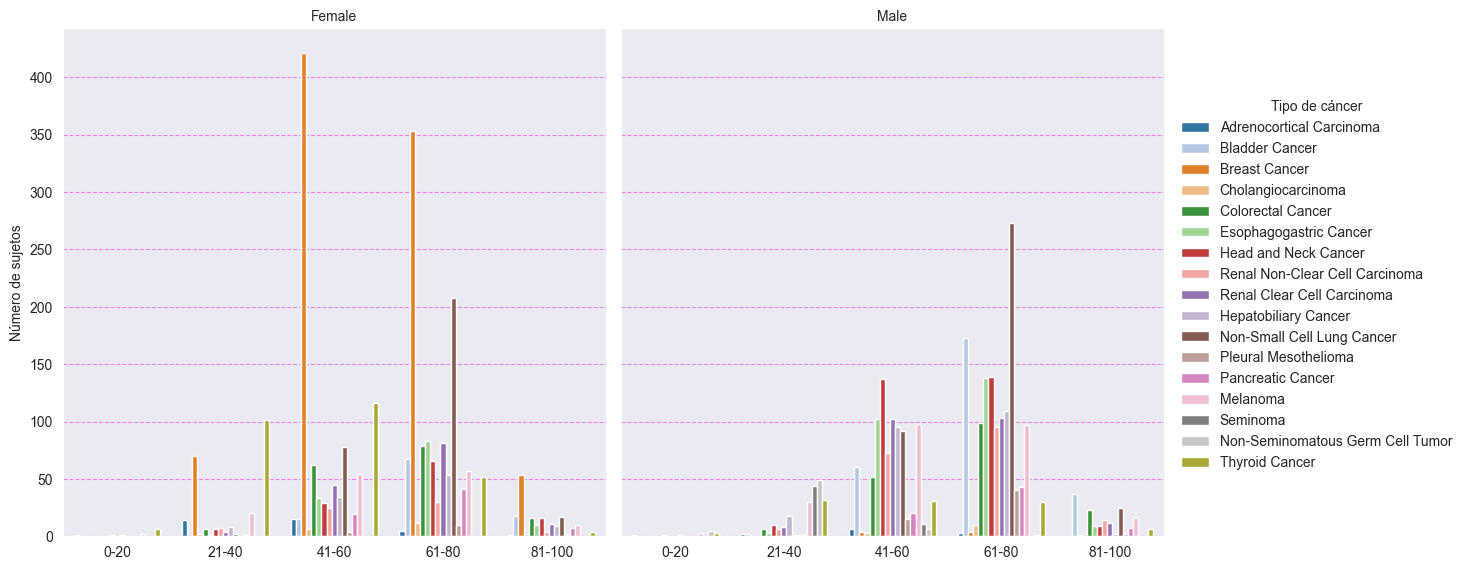

In [37]:
# Sex distribution per cancer type and tumor stage
plot = sns.catplot(data=dataset, x='AGE_GROUP', hue='CANCER_TYPE', col='SEX', kind='count', col_wrap=2, palette='tab20', height=6, aspect=1, order=labels)
# Order the x-axis categories
plot.set_titles(template="{col_name}")
plot.set_axis_labels(x_var="", y_var="Número de sujetos")
plot.legend.set_title("Tipo de cáncer")

# Save the plot to a file
plt.savefig('plots/AgeDistributionPerCancerTypeSex.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
# Add a new heading
document.add_heading(f"{heading_index}. Distribución de Sexos por Tipo de Cáncer y Grupos de Edad", 1)
heading_index += 1
# Save the plot to the word document
plot2doc(document, file_name, 'plots/AgeDistributionPerCancerTypeSex.png', w=6, h=4)